# **Retraining ML classification model by fine-tuning**

In [ ]:
# Set up working directory
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# to restrict the float value to 3 dcimal places
pd.set_option('display.float_format',lambda x:'%.3f'%x)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Installing the xgboost library using the 'pip' command
!pip install xgboost
# Importing XGBoost Regressor
from xgboost import XGBClassifier
#from sklearn.ensemble import AdaBoostClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,f1_score,precision_recall_curve,roc_curve,roc_auc_score,auc,recall_score,precision_score

In [ ]:
from google.colab import files
import joblib

In [ ]:
xgb_cv = joblib.load('Classification_model_20250918.pkl')

## **Several functions**

In [ ]:
# Function to print classification report and get confusion matrix in a proper format
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted, digits=3))

    cm = confusion_matrix(actual, predicted)

    labels = ['True Negative','False Positive','False Negative','True Positive']

    plt.figure(figsize = (6, 4))

    sns.heatmap(cm, annot = True,  fmt = '.2f', xticklabels = ['Inactive', 'Active'], yticklabels = ['Inactive', 'Active'])

    # Create a DataFrame for better readability
    #cm_df = pd.DataFrame(cm, index=['Actual Inactive', 'Actual Active'], columns=['Predicted Inactive', 'Predicted Active'])
    #print (cm_df)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
# Function to print classification report and get confusion matrix in a proper format
def metrics_curve (estimator, x, y):
    '''
    plot roc_auc & pr_auc for test dataset

    estimator: trainned model

    x: x_train or x_test

    y: y_train or y_test
    '''
    # predict probabilities for the test dataset
    pred = estimator.predict_proba(x)
    # keep probabilities for the positive outcome only
    pred = pred[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds_roc = roc_curve(y, pred)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    # calculate precision recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y, pred)
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y==1]) / len(y)
    # calculate the roc auc
    roc_auc = auc(fpr, tpr)
    # calculate the precision-recall auc
    pr_auc = auc(recall, precision)

    print('Best Threshold=%.3f, G-Mean=%.3f' % (thresholds_roc[ix], gmeans[ix]))

    fig, axs = plt.subplots(
        nrows=1,
        ncols = 2,      # Number of rows of the subplot grid = 2
        sharex = False,    # x-axis will be shared among all subplots
        #gridspec_kw = {"height_ratios": (0.5, 0.5)},
        figsize = (8, 4),
         )                   # Creating the 2 subplots


    # plot the roc curve for the model
    axs[0].plot([0,1], [0,1], linestyle='--', label='No Skill')
    axs[0].plot(fpr, tpr, color = 'red', label='ROC curve (area = %.3f)' % roc_auc)
    axs[0].scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve')
    axs[0].legend(fontsize=6)


    # plot the no skill precision-recall curve
    axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot the model precision-recall curve
    axs[1].plot(recall, precision, color = 'green', label='PR (area = %.3f)' % pr_auc)
    # axis labels
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision Recall Curve')
    # show the legend
    axs[1].legend(fontsize=6)
    # show the plot


    plt.tight_layout()
    plt.show()

In [ ]:
def metrics_threshold_roc (estimator):
    '''
    return threshold for whole dataset

    estimator: trainned model

    '''
    # predict probabilities for the test dataset
    pred = estimator.predict_proba(X)
    # keep probabilities for the positive outcome only
    pred = pred[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds_roc = roc_curve(Y, pred)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)

    return thresholds_roc[ix]

In [ ]:
def metrics_threshold_prc (estimator):
    '''
    return threshold for whole dataset

    estimator: trainned model

    '''
    # predict probabilities for the test dataset
    pred = estimator.predict_proba(X)
    # keep probabilities for the positive outcome only
    pred = pred[:, 1]
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(Y, pred)
    # calculate the F1_scores
    f1_scores = 2 * (precision * recall) / (precision + recall)
    # Find the index of the maximum F1-score
    best_idx = np.argmax(f1_scores)
    # Threshold corresponding to the best F1
    return thresholds[best_idx]

## **Trainning data split**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AhR/10_finalize/Training_data_classification_selected_descriptors_scaled.csv', index_col=0)

#Remove_list = pd.read_csv('/content/drive/MyDrive/AhR/07/Remove_list.csv')
#List = Remove_list['CASRN'].tolist()
#df_filtered = df.drop(List)

In [ ]:
df['Label'].value_counts()

Label
0.000    4946
1.000     832
Name: count, dtype: int64

In [ ]:
# Separating the target variable and other variables
X = df.drop(columns = ['Label'])
Y = df['Label']
# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4546, stratify = Y)

In [ ]:
X.shape, Y.shape

((5778, 529), (5778,))

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4622, 529), (1156, 529), (4622,), (1156,))

## **Mannual tuning for XGB_Model**

In [ ]:
# Fitting the random forest tree classifier on the training data
xgb = XGBClassifier(
           nthread = 100,
           device = 'cuda',
           booster = "gbtree",
           tree_method= "gpu_hist",
           sampling_method = 'gradient_based',
           max_delta_step = 1,
           colsample_bylevel= 0.90,
           colsample_bytree= 0.90,
           colsample_bynode= 0.90,
           subsample = 0.6,
           max_depth = 16,
           min_child_weight = 4,
           eta = 0.08,
           early_stopping_rounds = 8,
           gamma = 1,
           scale_pos_weight = 6,
           grow_policy = 'depthwise',
           refresh_leaf = 1, ##0 or 1
           #max_leaves = 1,
           updater = 'grow_gpu_hist',
           objective = 'binary:logistic',
           eval_metric = 'logloss',
           base_score = 0.4,
           num_parallel_tree = 14, #default is 1
           random_state = 4243)

# Fitting the model
xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)])
#xgb.fit(x_train, y_train, eval_set=[(X_eval, Y_eval)])

[0]	validation_0-logloss:0.55478
[1]	validation_0-logloss:0.54087
[2]	validation_0-logloss:0.52680
[3]	validation_0-logloss:0.51388
[4]	validation_0-logloss:0.50183
[5]	validation_0-logloss:0.48955
[6]	validation_0-logloss:0.47769
[7]	validation_0-logloss:0.46659
[8]	validation_0-logloss:0.45567
[9]	validation_0-logloss:0.44527
[10]	validation_0-logloss:0.43542
[11]	validation_0-logloss:0.42596
[12]	validation_0-logloss:0.41692
[13]	validation_0-logloss:0.40855
[14]	validation_0-logloss:0.40030
[15]	validation_0-logloss:0.39220
[16]	validation_0-logloss:0.38438
[17]	validation_0-logloss:0.37709
[18]	validation_0-logloss:0.37046
[19]	validation_0-logloss:0.36381
[20]	validation_0-logloss:0.35765
[21]	validation_0-logloss:0.35150
[22]	validation_0-logloss:0.34606
[23]	validation_0-logloss:0.34075
[24]	validation_0-logloss:0.33584
[25]	validation_0-logloss:0.33117
[26]	validation_0-logloss:0.32683
[27]	validation_0-logloss:0.32274
[28]	validation_0-logloss:0.31860
[29]	validation_0-loglos

XGBClassifier(base_score=0.4, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9,
              device='cuda', early_stopping_rounds=8, enable_categorical=False,
              eta=0.08, eval_metric='logloss', feature_types=None,
              feature_weights=None, gamma=1, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=16,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

Best Threshold=0.127, G-Mean=0.812


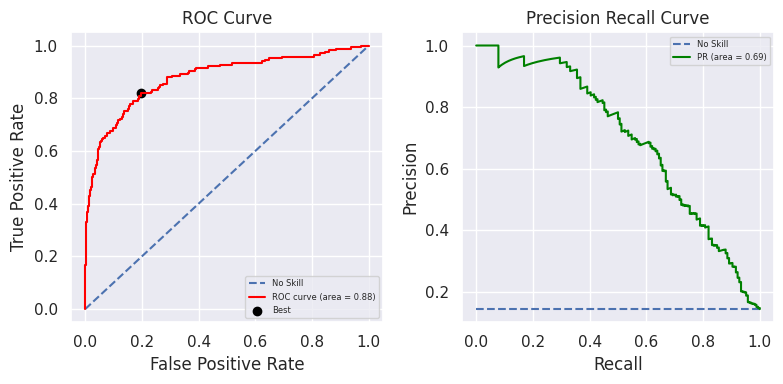

In [ ]:
metrics_curve (xgb, x_test, y_test)

Best Threshold=0.850, G-Mean=1.000


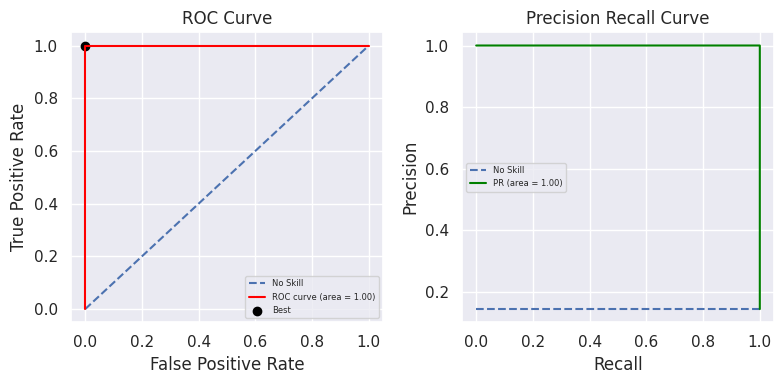

In [ ]:
metrics_curve (xgb, x_train, y_train)

Best Threshold=0.406, G-Mean=0.956


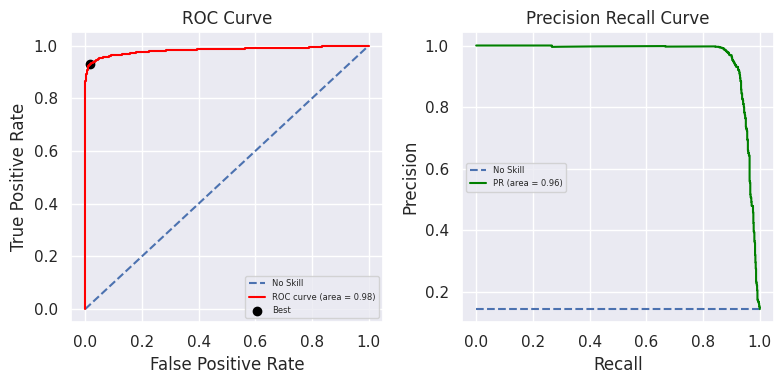

In [ ]:
metrics_curve (xgb, X, Y)

In [ ]:
metrics_threshold_roc(xgb)

np.float32(0.40595272)

In [ ]:
metrics_threshold_prc(xgb)

np.float32(0.6851272)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3956
         1.0       0.97      1.00      0.99       666

    accuracy                           1.00      4622
   macro avg       0.99      1.00      0.99      4622
weighted avg       1.00      1.00      1.00      4622



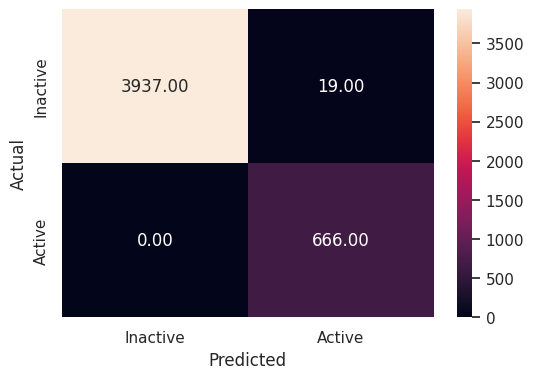

In [ ]:
# Checking the model performance on training data with changed threshold
predicted_proba_xgb = xgb.predict_proba(x_train)
y_pred_train_xgb = (predicted_proba_xgb [:,1] >= 0.431).astype('int')
metrics_score(y_train, y_pred_train_xgb)

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       990
         1.0       0.59      0.67      0.63       166

    accuracy                           0.89      1156
   macro avg       0.77      0.80      0.78      1156
weighted avg       0.89      0.89      0.89      1156



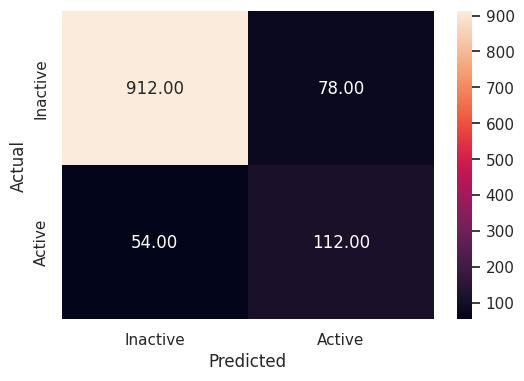

In [ ]:
# Checking the model performance on training data with changed threshold
predicted_proba_test_xgb = xgb.predict_proba(x_test)
y_pred_test_xgb = (predicted_proba_test_xgb[:,1] >= 0.397).astype('int')
metrics_score(y_test, y_pred_test_xgb)

In [ ]:
# Convert Series to DataFrame with index as a column
df_test_prediction = y_test.reset_index()

# Rename columns
df_test_prediction.columns = ['index', 'Label']

df_test_prediction['prediction'] = y_pred_test_xgb

In [ ]:
FN = df_test_prediction[(df_test_prediction['Label'] == 1) & (df_test_prediction['prediction'] == 0)]
FP = df_test_prediction[(df_test_prediction['Label'] == 0) & (df_test_prediction['prediction'] == 1)]

In [ ]:
FP['index']

41        3736-81-0
70      475207-59-1
96       53716-49-7
105       3030-53-3
190     150683-30-0
222       3562-84-3
307        122-42-9
312        537-17-7
356        576-24-9
397     162408-66-4
399         90-44-8
420         90-98-2
423      24526-64-5
459       5003-48-5
490         70-30-4
533         84-97-9
565       4265-16-1
618     129722-12-9
655      22494-42-4
659      25899-50-7
676        119-75-5
710     200940-23-4
724     132907-72-3
772        486-25-9
780        103-41-3
784      57646-30-7
792        101-02-0
800        120-12-7
802       2275-14-1
825      68844-77-9
830        526-08-9
860        7/5/6804
870      92623-83-1
872         88-74-4
900       1951-25-3
921      76674-21-0
952        520-53-6
953       6398-98-7
968        120-78-5
1008        61-68-7
1021     72332-33-3
1027     16506-27-7
1046       340-57-8
1051      1014-70-6
1084     68298-46-4
1103    127625-29-0
1122       133-90-4
1144       120-75-2
1153       318-98-9
Name: index, dtype: object

In [ ]:
FN['index']

28        5331-43-1
68       30748-29-9
97         108-65-6
129       5809-23-4
162      21540-35-2
169       6632-68-4
173         83-26-1
177        610-66-2
180      82586-52-5
181     118635-52-2
186      13284-42-9
189      63903-74-2
191        638-29-9
233         99-97-8
263        117-80-6
286        529-34-0
297     898128-45-5
325         91-61-2
341         95-77-2
344        120-62-7
381      83164-33-4
414     141845-82-1
423         95-69-2
459        611-20-1
473      93957-54-1
482     123312-89-0
497      42924-53-8
501      32329-20-7
525        145-73-3
530     290352-28-2
550        614-80-2
573        108-69-0
603      51410-30-1
608     115103-85-0
640        375-95-1
641      15791-78-3
650     153233-91-1
655        120-72-9
666      58546-54-6
681      24140-30-5
682      17737-65-4
685      21285-46-1
740       3710-84-7
743       1480-19-9
748        532-27-4
755      31218-83-4
779     128517-07-7
781      49763-96-4
812        101-37-1
834     143390-89-0
881       2779-55-7
973      18046-21-4
984      66575-29-9
986        573-20-6
995        619-17-0
1024      5174-32-3
1026     80809-81-0
1049       111-76-2
1064    104054-27-5
1067        98-07-7
1074    391210-10-9
1109       485-47-2
1112     31842-01-0
1134        77-09-8
1142     98730-04-2
Name: index, dtype: object

## **Optimization with cross validation using the parameters from hypertuning**

{'max_depth': np.int64(16),
 'min_child_weight': np.int64(4),
 'num_parallel_tree': np.int64(14),
 'subsample': np.float64(0.6000000000000001)}



 It may take 100 calculation units for several hours

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
# Splitting the data into train and test sets
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state= 2423)

In [ ]:
# Fitting the random forest tree classifier on the training data
xgb_cv = XGBClassifier(
           nthread = 100,
           device = 'cuda',
           #booster = "dart",
           booster = "gbtree",
           tree_method= "gpu_hist",
           sampling_method = 'gradient_based',
           #sampling_method = 'uniform',
           max_delta_step = 1,
           colsample_bylevel= 0.9,
           colsample_bytree= 0.9,
           colsample_bynode= 0.9,
           subsample = 0.4,
           max_depth = 8,
           min_child_weight = 8,
           eta = 0.1,
           early_stopping_rounds = 6,
           gamma = 1,
           scale_pos_weight = 6,
           grow_policy = 'depthwise',
           refresh_leaf = 1, ##0 or 1
           #max_leaves = 1,
           updater = 'grow_gpu_hist',
           objective = 'binary:logistic',
           eval_metric = 'logloss',
           base_score = 0.8,
           num_parallel_tree = 10, #default is 1
           random_state = 4243)

In [ ]:
# Fitting the random forest tree classifier on the training data
xgb_cv = XGBClassifier(
           nthread = 100,
           device = 'cuda',
           #booster = "dart",
           booster = "gbtree",
           tree_method= "gpu_hist",
           sampling_method = 'gradient_based',
           #sampling_method = 'uniform',
           max_delta_step = 1,
           colsample_bylevel= 0.9,
           colsample_bytree= 0.9,
           colsample_bynode= 0.9,
           subsample = 0.6,
           max_depth = 16,
           min_child_weight = 4,
           eta = 0.1,
           early_stopping_rounds = 6,
           gamma = 1,
           scale_pos_weight = 6,
           grow_policy = 'depthwise',
           refresh_leaf = 1, ##0 or 1
           #max_leaves = 1,
           updater = 'grow_gpu_hist',
           objective = 'binary:logistic',
           eval_metric = 'logloss',
           base_score = 0.8,
           num_parallel_tree = 14, #default is 1
           random_state = 4243)

[0]	validation_0-logloss:1.35082
[1]	validation_0-logloss:1.29302
[2]	validation_0-logloss:1.23644
[3]	validation_0-logloss:1.18256
[4]	validation_0-logloss:1.13110
[5]	validation_0-logloss:1.08132
[6]	validation_0-logloss:1.03384
[7]	validation_0-logloss:0.98850
[8]	validation_0-logloss:0.94497
[9]	validation_0-logloss:0.90323
[10]	validation_0-logloss:0.86360
[11]	validation_0-logloss:0.82587
[12]	validation_0-logloss:0.79038
[13]	validation_0-logloss:0.75640
[14]	validation_0-logloss:0.72410
[15]	validation_0-logloss:0.69345
[16]	validation_0-logloss:0.66499
[17]	validation_0-logloss:0.63837
[18]	validation_0-logloss:0.61315
[19]	validation_0-logloss:0.58973
[20]	validation_0-logloss:0.56680
[21]	validation_0-logloss:0.54506
[22]	validation_0-logloss:0.52512
[23]	validation_0-logloss:0.50600
[24]	validation_0-logloss:0.48873
[25]	validation_0-logloss:0.47233
[26]	validation_0-logloss:0.45655
[27]	validation_0-logloss:0.44204
[28]	validation_0-logloss:0.42863
[29]	validation_0-loglos

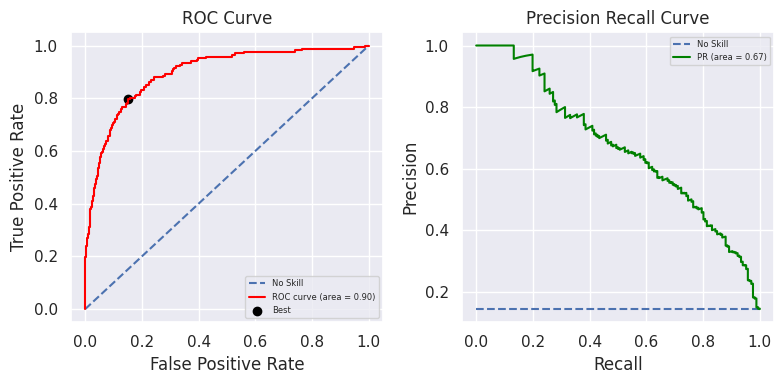

[0]	validation_0-logloss:1.35217
[1]	validation_0-logloss:1.29537
[2]	validation_0-logloss:1.24058
[3]	validation_0-logloss:1.18751
[4]	validation_0-logloss:1.13659
[5]	validation_0-logloss:1.08712
[6]	validation_0-logloss:1.04018
[7]	validation_0-logloss:0.99500
[8]	validation_0-logloss:0.95123
[9]	validation_0-logloss:0.90969
[10]	validation_0-logloss:0.87021
[11]	validation_0-logloss:0.83194
[12]	validation_0-logloss:0.79605
[13]	validation_0-logloss:0.76215
[14]	validation_0-logloss:0.72883
[15]	validation_0-logloss:0.69776
[16]	validation_0-logloss:0.66822
[17]	validation_0-logloss:0.64060
[18]	validation_0-logloss:0.61432
[19]	validation_0-logloss:0.58981
[20]	validation_0-logloss:0.56613
[21]	validation_0-logloss:0.54416
[22]	validation_0-logloss:0.52390
[23]	validation_0-logloss:0.50450
[24]	validation_0-logloss:0.48691
[25]	validation_0-logloss:0.46972
[26]	validation_0-logloss:0.45420
[27]	validation_0-logloss:0.43911
[28]	validation_0-logloss:0.42545
[29]	validation_0-loglos

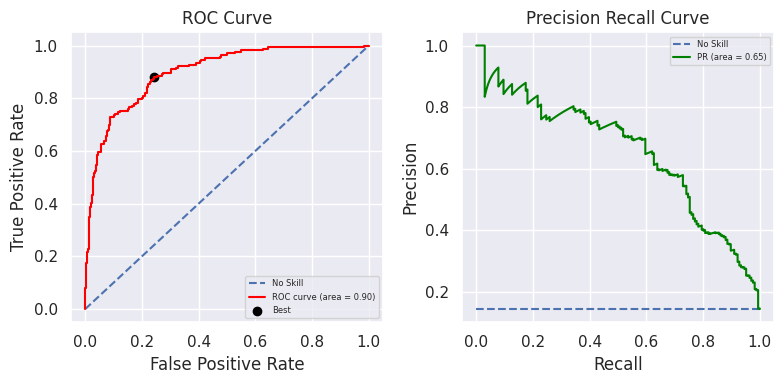

[0]	validation_0-logloss:1.35208
[1]	validation_0-logloss:1.29547
[2]	validation_0-logloss:1.24059
[3]	validation_0-logloss:1.18713
[4]	validation_0-logloss:1.13598
[5]	validation_0-logloss:1.08757
[6]	validation_0-logloss:1.04004
[7]	validation_0-logloss:0.99502
[8]	validation_0-logloss:0.95145
[9]	validation_0-logloss:0.91037
[10]	validation_0-logloss:0.87094
[11]	validation_0-logloss:0.83333
[12]	validation_0-logloss:0.79820
[13]	validation_0-logloss:0.76392
[14]	validation_0-logloss:0.73166
[15]	validation_0-logloss:0.70158
[16]	validation_0-logloss:0.67314
[17]	validation_0-logloss:0.64579
[18]	validation_0-logloss:0.62033
[19]	validation_0-logloss:0.59583
[20]	validation_0-logloss:0.57305
[21]	validation_0-logloss:0.55138
[22]	validation_0-logloss:0.53090
[23]	validation_0-logloss:0.51151
[24]	validation_0-logloss:0.49384
[25]	validation_0-logloss:0.47677
[26]	validation_0-logloss:0.46083
[27]	validation_0-logloss:0.44621
[28]	validation_0-logloss:0.43249
[29]	validation_0-loglos

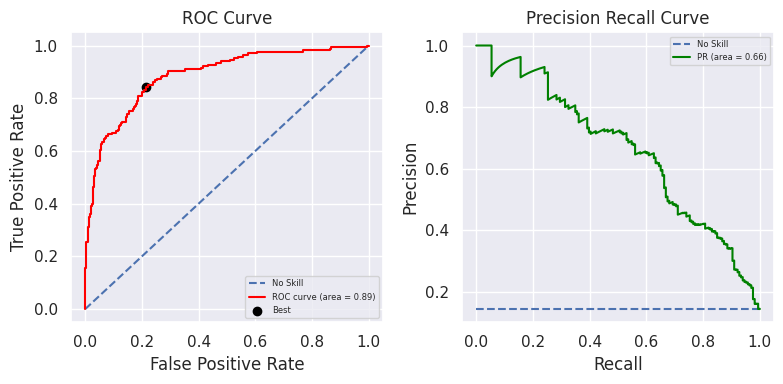

[0]	validation_0-logloss:1.35020
[1]	validation_0-logloss:1.29259
[2]	validation_0-logloss:1.23688
[3]	validation_0-logloss:1.18359
[4]	validation_0-logloss:1.13097
[5]	validation_0-logloss:1.08022
[6]	validation_0-logloss:1.03211
[7]	validation_0-logloss:0.98622
[8]	validation_0-logloss:0.94221
[9]	validation_0-logloss:0.89936
[10]	validation_0-logloss:0.85964
[11]	validation_0-logloss:0.82143
[12]	validation_0-logloss:0.78579
[13]	validation_0-logloss:0.75174
[14]	validation_0-logloss:0.71931
[15]	validation_0-logloss:0.68897
[16]	validation_0-logloss:0.66033
[17]	validation_0-logloss:0.63327
[18]	validation_0-logloss:0.60731
[19]	validation_0-logloss:0.58303
[20]	validation_0-logloss:0.56032
[21]	validation_0-logloss:0.53840
[22]	validation_0-logloss:0.51819
[23]	validation_0-logloss:0.49893
[24]	validation_0-logloss:0.48104
[25]	validation_0-logloss:0.46419
[26]	validation_0-logloss:0.44827
[27]	validation_0-logloss:0.43343
[28]	validation_0-logloss:0.41982
[29]	validation_0-loglos

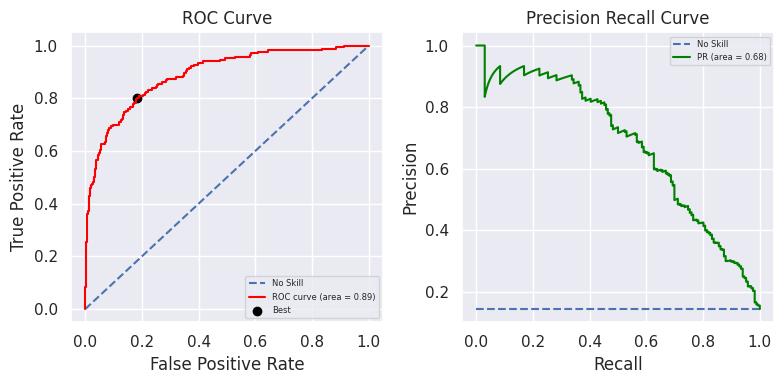

[0]	validation_0-logloss:1.34970
[1]	validation_0-logloss:1.29046
[2]	validation_0-logloss:1.23373
[3]	validation_0-logloss:1.17850
[4]	validation_0-logloss:1.12561
[5]	validation_0-logloss:1.07451
[6]	validation_0-logloss:1.02582
[7]	validation_0-logloss:0.97923
[8]	validation_0-logloss:0.93426
[9]	validation_0-logloss:0.89145
[10]	validation_0-logloss:0.85040
[11]	validation_0-logloss:0.81138
[12]	validation_0-logloss:0.77428
[13]	validation_0-logloss:0.73907
[14]	validation_0-logloss:0.70528
[15]	validation_0-logloss:0.67341
[16]	validation_0-logloss:0.64364
[17]	validation_0-logloss:0.61534
[18]	validation_0-logloss:0.58841
[19]	validation_0-logloss:0.56327
[20]	validation_0-logloss:0.53950
[21]	validation_0-logloss:0.51743
[22]	validation_0-logloss:0.49638
[23]	validation_0-logloss:0.47664
[24]	validation_0-logloss:0.45830
[25]	validation_0-logloss:0.44103
[26]	validation_0-logloss:0.42469
[27]	validation_0-logloss:0.40992
[28]	validation_0-logloss:0.39609
[29]	validation_0-loglos

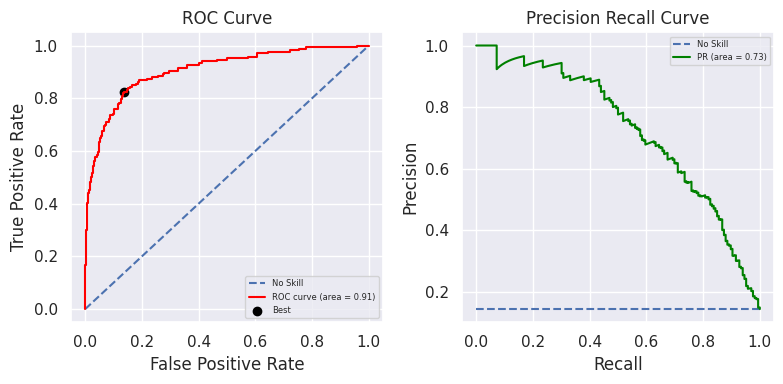

In [ ]:
for train_index, test_index in sss.split(X, Y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    #print("TRAIN indices:", train_index)
    #print("TEST indices:", test_index)
    #print("Distinct classes in TRAIN:", np.unique(y_train))
    #print("Distinct classes in TEST:", np.unique(y_test))
    #print()  # Blank line for better readability
    #Fitting the model
    xgb_cv.fit(
               x_train, y_train,
               eval_set=[(x_test, y_test)],
    )
    metrics_curve(xgb_cv, x_test, y_test)
    #y_pred_test_xgb_cv = xgb_cv.predict(x_test)
    #metrics_score(y_test, y_pred_test_xgb_cv)

    #y_test_xgb_cv_proba = xgb_cv.predict_proba(x_test)
    #y_test_xgb_cv_prediction = (y_test_xgb_cv_proba [:,1] >= 0.57).astype('int')
    #metrics_score(y_test, y_test_xgb_cv_prediction)

Best Threshold=0.446, G-Mean=0.961


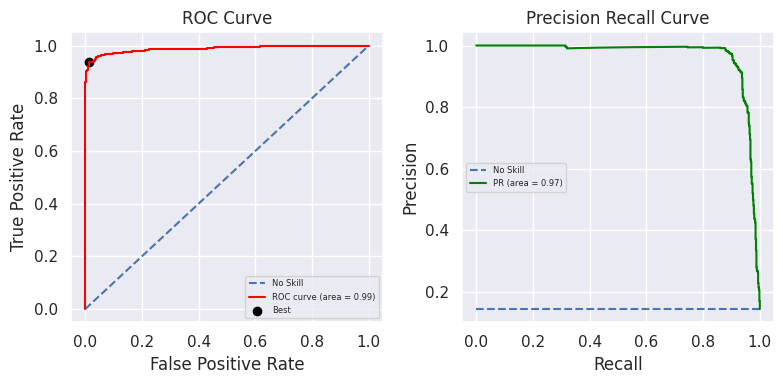

In [ ]:
metrics_curve (xgb_cv, x_train, y_train)

Best Threshold=0.524, G-Mean=0.949


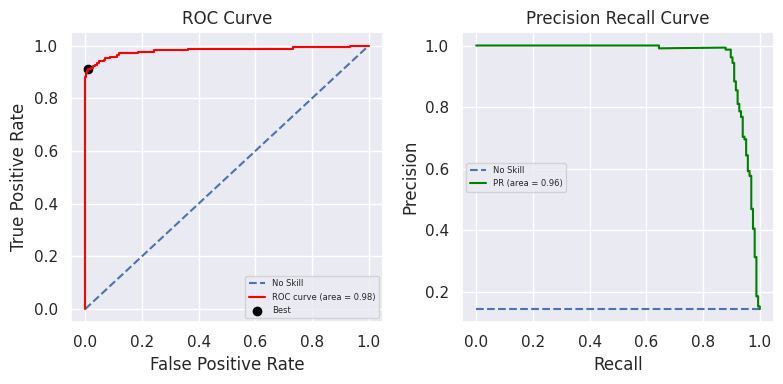

In [ ]:
metrics_curve (xgb_cv, x_test, y_test)

Best Threshold=0.446, G-Mean=0.958


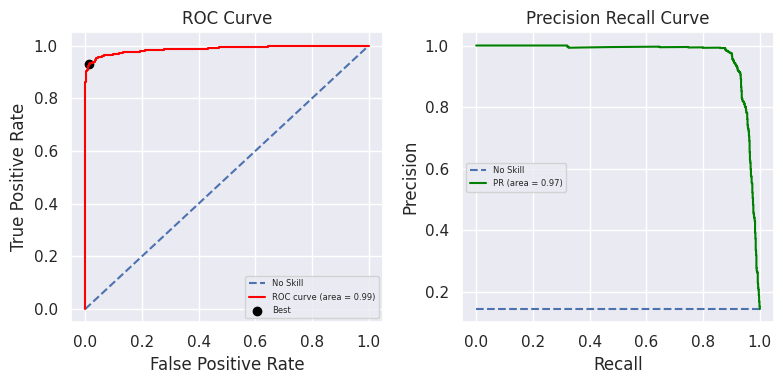

In [ ]:
metrics_curve (xgb_cv, X, Y)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      3956
         1.0       0.91      0.94      0.92       666

    accuracy                           0.98      4622
   macro avg       0.95      0.96      0.96      4622
weighted avg       0.98      0.98      0.98      4622



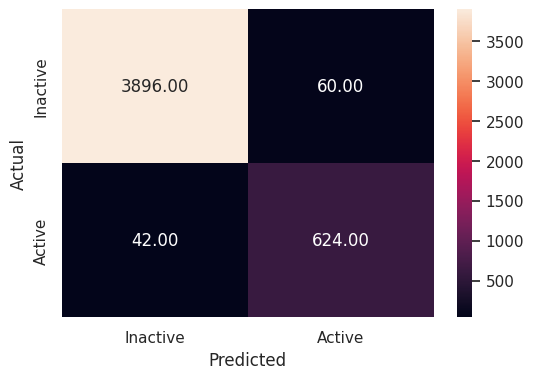

In [ ]:
# Checking the model performance on training data with changed threshold
predicted_proba_train_xgb_cv = xgb_cv.predict_proba(x_train)
y_pred_train_xgb_cv = (predicted_proba_train_xgb_cv[:,1] >= 0.446).astype('int')
metrics_score(y_train, y_pred_train_xgb_cv)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       990
         1.0       0.91      0.91      0.91       166

    accuracy                           0.97      1156
   macro avg       0.95      0.95      0.95      1156
weighted avg       0.97      0.97      0.97      1156



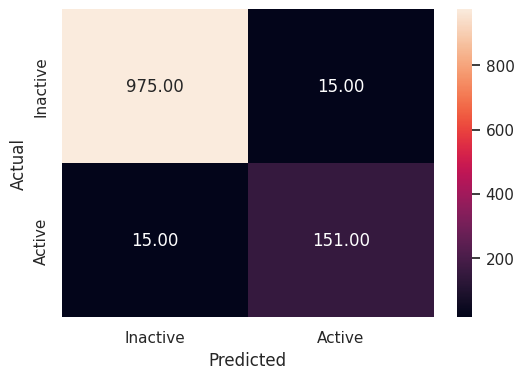

In [ ]:
# Checking the model performance on training data with changed threshold
predicted_proba_test_xgb_cv = xgb_cv.predict_proba(x_test)
y_pred_test_xgb_cv = (predicted_proba_test_xgb_cv[:,1] >= 0.446).astype('int')
metrics_score(y_test, y_pred_test_xgb_cv)

## **Optimization with cross validation using the manually tuned parameters**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
# Splitting the data into train and test sets
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state= 2423)

In [ ]:
# Fitting the random forest tree classifier on the training data
xgb_cv = XGBClassifier(
           nthread = 100,
           device = 'cuda',
           #booster = "dart",
           booster = "gbtree",
           tree_method= "gpu_hist",
           sampling_method = 'gradient_based',
           #sampling_method = 'uniform',
           max_delta_step = 1,
           colsample_bylevel= 0.9,
           colsample_bytree= 0.9,
           colsample_bynode= 0.9,
           subsample = 0.4,
           max_depth = 8,
           min_child_weight = 8,
           eta = 0.1,
           early_stopping_rounds = 6,
           gamma = 1,
           scale_pos_weight = 6,
           grow_policy = 'depthwise',
           refresh_leaf = 1, ##0 or 1
           #max_leaves = 1,
           updater = 'grow_gpu_hist',
           objective = 'binary:logistic',
           eval_metric = 'logloss',
           base_score = 0.8,
           num_parallel_tree = 10, #default is 1
           random_state = 4243)

[0]	validation_0-logloss:1.35038
[1]	validation_0-logloss:1.29344
[2]	validation_0-logloss:1.23773
[3]	validation_0-logloss:1.18426
[4]	validation_0-logloss:1.13352
[5]	validation_0-logloss:1.08467
[6]	validation_0-logloss:1.03768
[7]	validation_0-logloss:0.99307
[8]	validation_0-logloss:0.94998
[9]	validation_0-logloss:0.90976
[10]	validation_0-logloss:0.87100
[11]	validation_0-logloss:0.83509
[12]	validation_0-logloss:0.79898
[13]	validation_0-logloss:0.76661
[14]	validation_0-logloss:0.73568
[15]	validation_0-logloss:0.70666
[16]	validation_0-logloss:0.67923
[17]	validation_0-logloss:0.65370
[18]	validation_0-logloss:0.62899
[19]	validation_0-logloss:0.60625
[20]	validation_0-logloss:0.58513
[21]	validation_0-logloss:0.56530
[22]	validation_0-logloss:0.54623
[23]	validation_0-logloss:0.52897
[24]	validation_0-logloss:0.51257
[25]	validation_0-logloss:0.49734
[26]	validation_0-logloss:0.48279
[27]	validation_0-logloss:0.46979
[28]	validation_0-logloss:0.45739
[29]	validation_0-loglos

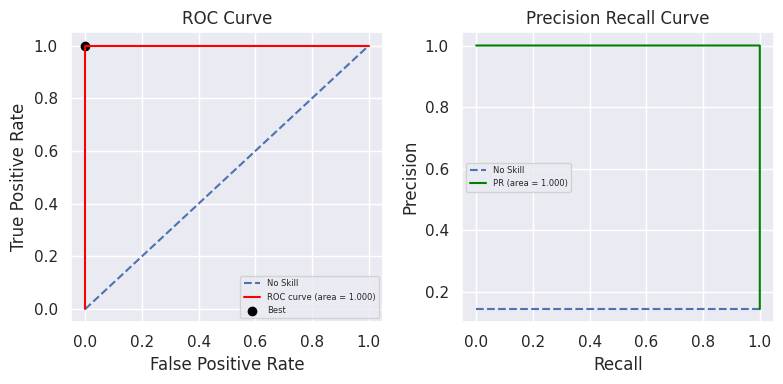

Best Threshold=0.212, G-Mean=0.826


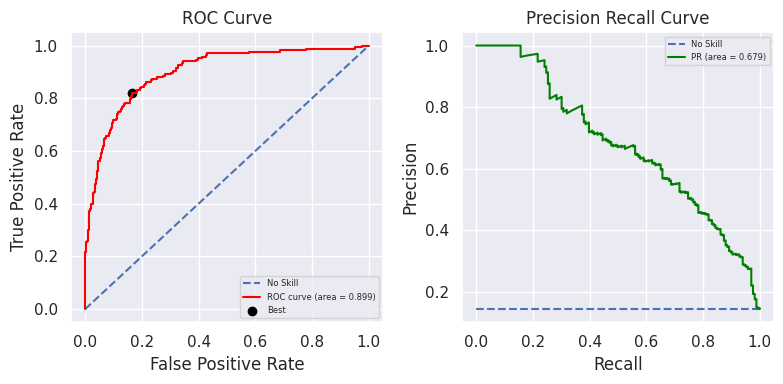

Best Threshold=0.350, G-Mean=0.957


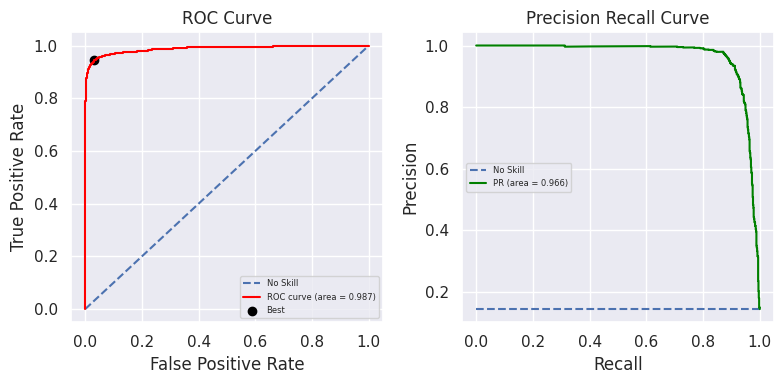

              precision    recall  f1-score   support

         0.0      1.000     0.993     0.997      3956
         1.0      0.962     1.000     0.981       666

    accuracy                          0.994      4622
   macro avg      0.981     0.997     0.989      4622
weighted avg      0.995     0.994     0.994      4622



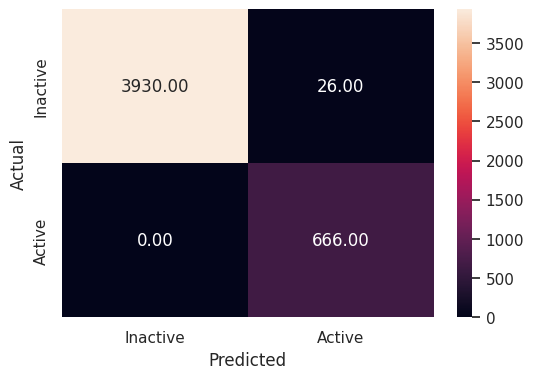

              precision    recall  f1-score   support

         0.0      0.938     0.932     0.935       990
         1.0      0.610     0.633     0.621       166

    accuracy                          0.889      1156
   macro avg      0.774     0.782     0.778      1156
weighted avg      0.891     0.889     0.890      1156



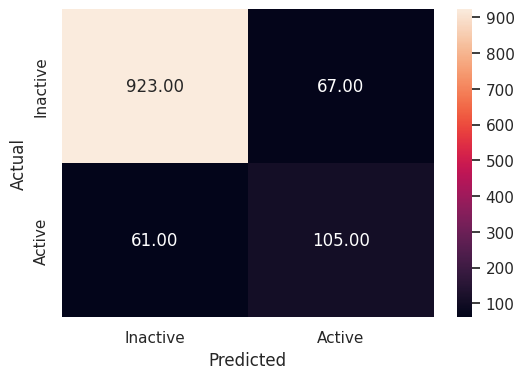

              precision    recall  f1-score   support

         0.0      0.988     0.981     0.984      4946
         1.0      0.892     0.927     0.909       832

    accuracy                          0.973      5778
   macro avg      0.940     0.954     0.947      5778
weighted avg      0.974     0.973     0.974      5778



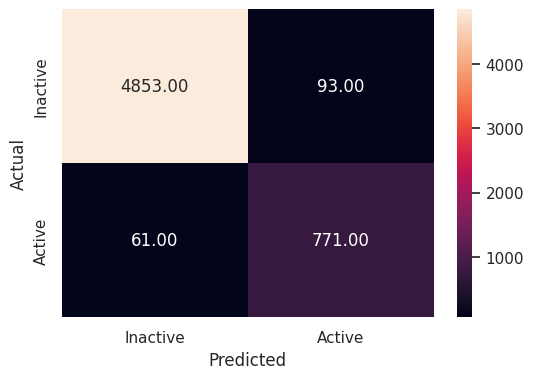

[0]	validation_0-logloss:1.35243
[1]	validation_0-logloss:1.29536
[2]	validation_0-logloss:1.24127
[3]	validation_0-logloss:1.18890
[4]	validation_0-logloss:1.13874
[5]	validation_0-logloss:1.09087
[6]	validation_0-logloss:1.04464
[7]	validation_0-logloss:0.99996
[8]	validation_0-logloss:0.95796
[9]	validation_0-logloss:0.91763
[10]	validation_0-logloss:0.87989
[11]	validation_0-logloss:0.84361
[12]	validation_0-logloss:0.80890
[13]	validation_0-logloss:0.77624
[14]	validation_0-logloss:0.74553
[15]	validation_0-logloss:0.71605
[16]	validation_0-logloss:0.68849
[17]	validation_0-logloss:0.66247
[18]	validation_0-logloss:0.63797
[19]	validation_0-logloss:0.61415
[20]	validation_0-logloss:0.59264
[21]	validation_0-logloss:0.57186
[22]	validation_0-logloss:0.55290
[23]	validation_0-logloss:0.53536
[24]	validation_0-logloss:0.51952
[25]	validation_0-logloss:0.50409
[26]	validation_0-logloss:0.49013
[27]	validation_0-logloss:0.47684
[28]	validation_0-logloss:0.46432
[29]	validation_0-loglos

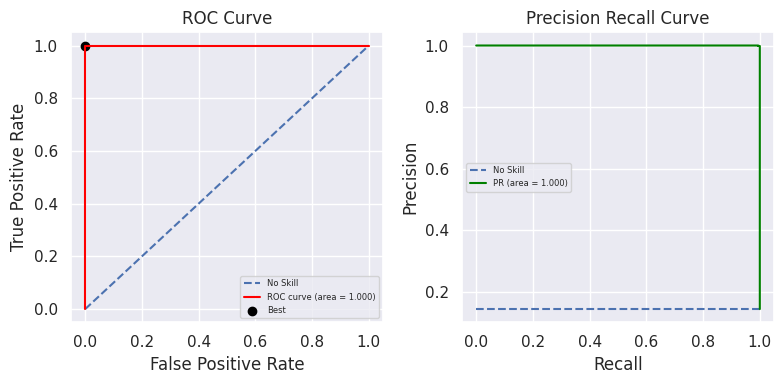

Best Threshold=0.126, G-Mean=0.822


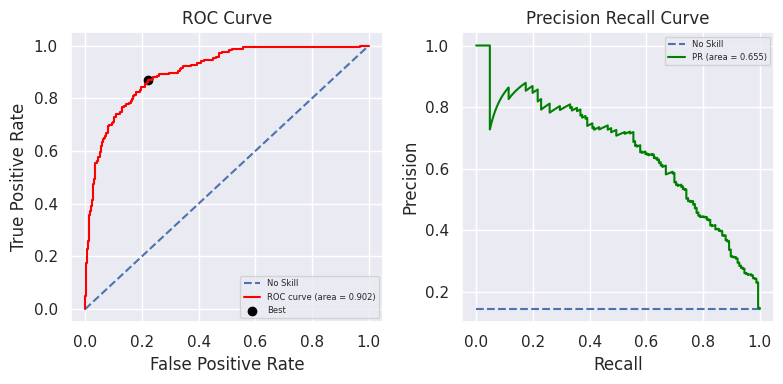

Best Threshold=0.414, G-Mean=0.958


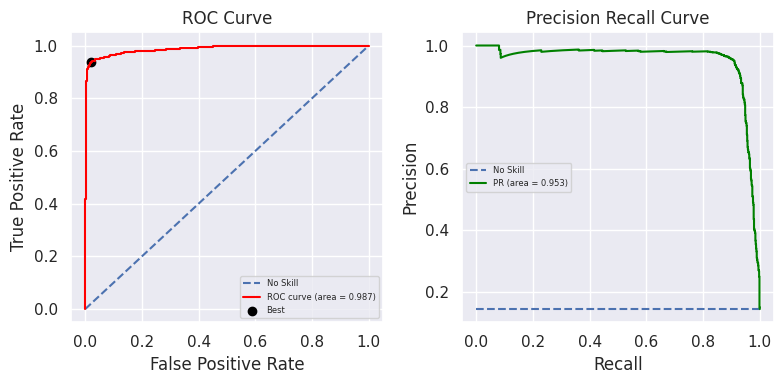

              precision    recall  f1-score   support

         0.0      1.000     0.994     0.997      3956
         1.0      0.968     1.000     0.984       666

    accuracy                          0.995      4622
   macro avg      0.984     0.997     0.990      4622
weighted avg      0.995     0.995     0.995      4622



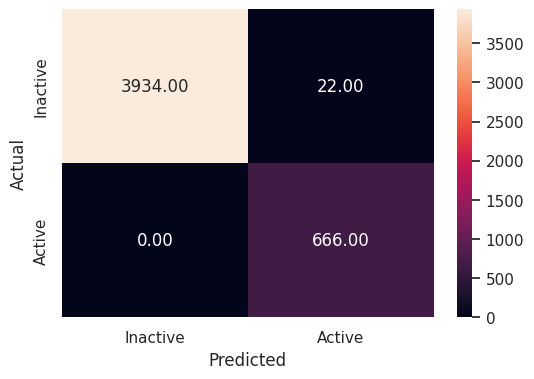

              precision    recall  f1-score   support

         0.0      0.943     0.924     0.934       990
         1.0      0.597     0.669     0.631       166

    accuracy                          0.888      1156
   macro avg      0.770     0.796     0.782      1156
weighted avg      0.894     0.888     0.890      1156



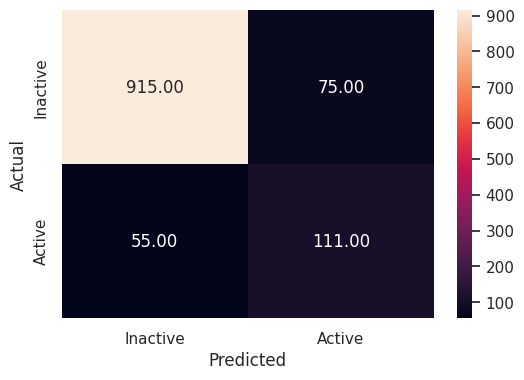

              precision    recall  f1-score   support

         0.0      0.989     0.980     0.985      4946
         1.0      0.889     0.934     0.911       832

    accuracy                          0.974      5778
   macro avg      0.939     0.957     0.948      5778
weighted avg      0.974     0.974     0.974      5778



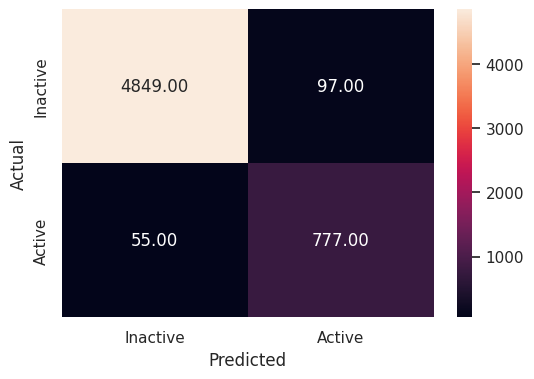

[0]	validation_0-logloss:1.35200
[1]	validation_0-logloss:1.29524
[2]	validation_0-logloss:1.24103
[3]	validation_0-logloss:1.18801
[4]	validation_0-logloss:1.13659
[5]	validation_0-logloss:1.08913
[6]	validation_0-logloss:1.04244
[7]	validation_0-logloss:0.99918
[8]	validation_0-logloss:0.95697
[9]	validation_0-logloss:0.91746
[10]	validation_0-logloss:0.87938
[11]	validation_0-logloss:0.84337
[12]	validation_0-logloss:0.80873
[13]	validation_0-logloss:0.77631
[14]	validation_0-logloss:0.74517
[15]	validation_0-logloss:0.71661
[16]	validation_0-logloss:0.68960
[17]	validation_0-logloss:0.66390
[18]	validation_0-logloss:0.63966
[19]	validation_0-logloss:0.61670
[20]	validation_0-logloss:0.59568
[21]	validation_0-logloss:0.57652
[22]	validation_0-logloss:0.55725
[23]	validation_0-logloss:0.53920
[24]	validation_0-logloss:0.52346
[25]	validation_0-logloss:0.50810
[26]	validation_0-logloss:0.49398
[27]	validation_0-logloss:0.48025
[28]	validation_0-logloss:0.46765
[29]	validation_0-loglos

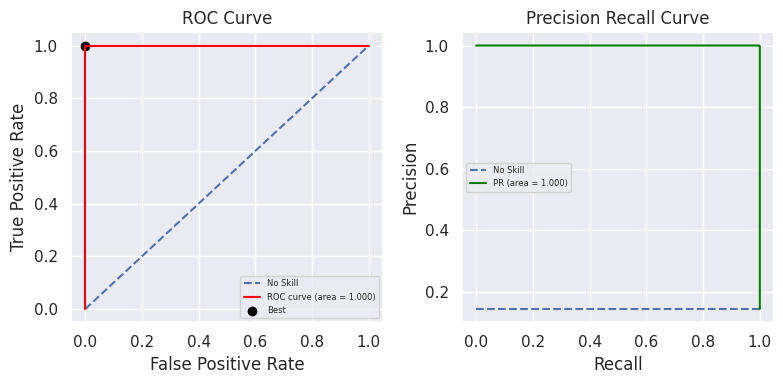

Best Threshold=0.118, G-Mean=0.810


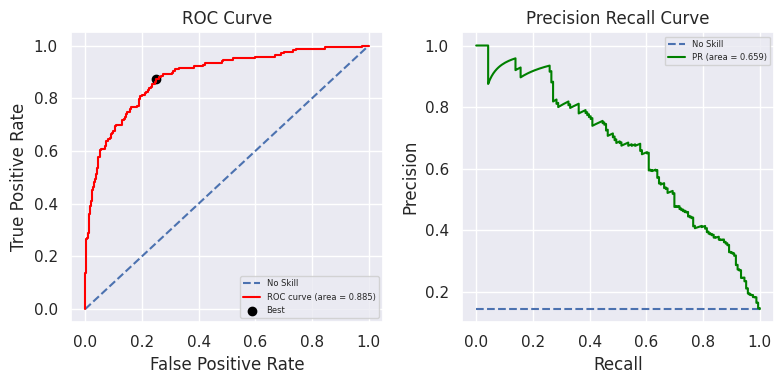

Best Threshold=0.476, G-Mean=0.954


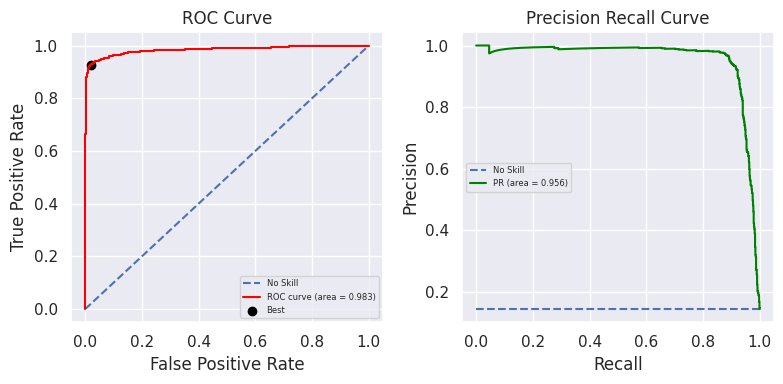

              precision    recall  f1-score   support

         0.0      1.000     0.993     0.996      3956
         1.0      0.958     1.000     0.979       666

    accuracy                          0.994      4622
   macro avg      0.979     0.996     0.988      4622
weighted avg      0.994     0.994     0.994      4622



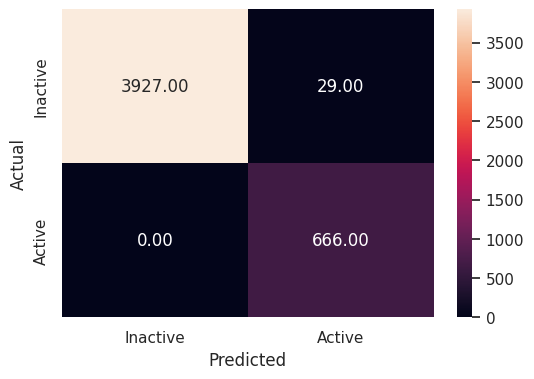

              precision    recall  f1-score   support

         0.0      0.938     0.922     0.930       990
         1.0      0.579     0.639     0.607       166

    accuracy                          0.881      1156
   macro avg      0.759     0.780     0.769      1156
weighted avg      0.887     0.881     0.884      1156



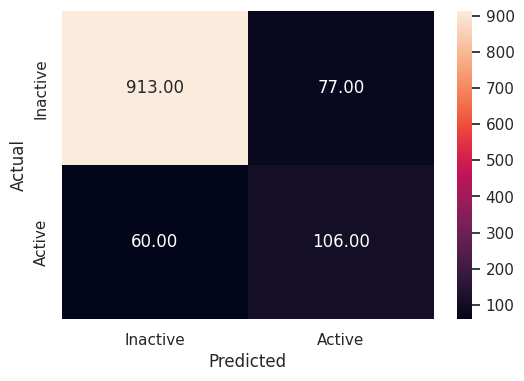

              precision    recall  f1-score   support

         0.0      0.988     0.979     0.983      4946
         1.0      0.879     0.928     0.903       832

    accuracy                          0.971      5778
   macro avg      0.934     0.953     0.943      5778
weighted avg      0.972     0.971     0.972      5778



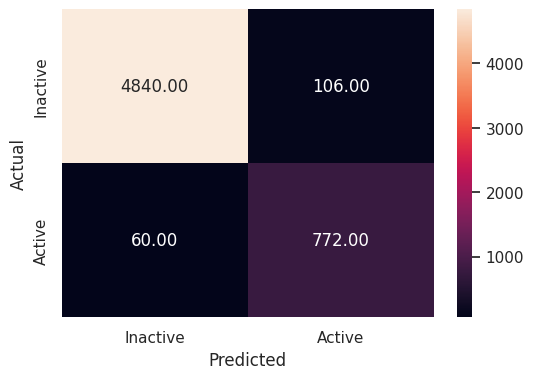

[0]	validation_0-logloss:1.35112
[1]	validation_0-logloss:1.29321
[2]	validation_0-logloss:1.23775
[3]	validation_0-logloss:1.18356
[4]	validation_0-logloss:1.13274
[5]	validation_0-logloss:1.08276
[6]	validation_0-logloss:1.03560
[7]	validation_0-logloss:0.99042
[8]	validation_0-logloss:0.94840
[9]	validation_0-logloss:0.90753
[10]	validation_0-logloss:0.86941
[11]	validation_0-logloss:0.83205
[12]	validation_0-logloss:0.79726
[13]	validation_0-logloss:0.76490
[14]	validation_0-logloss:0.73383
[15]	validation_0-logloss:0.70432
[16]	validation_0-logloss:0.67699
[17]	validation_0-logloss:0.65087
[18]	validation_0-logloss:0.62624
[19]	validation_0-logloss:0.60376
[20]	validation_0-logloss:0.58236
[21]	validation_0-logloss:0.56179
[22]	validation_0-logloss:0.54290
[23]	validation_0-logloss:0.52544
[24]	validation_0-logloss:0.50914
[25]	validation_0-logloss:0.49365
[26]	validation_0-logloss:0.47937
[27]	validation_0-logloss:0.46585
[28]	validation_0-logloss:0.45310
[29]	validation_0-loglos

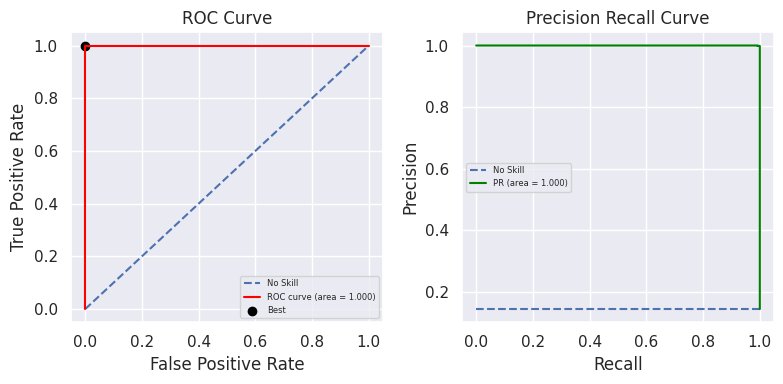

Best Threshold=0.171, G-Mean=0.810


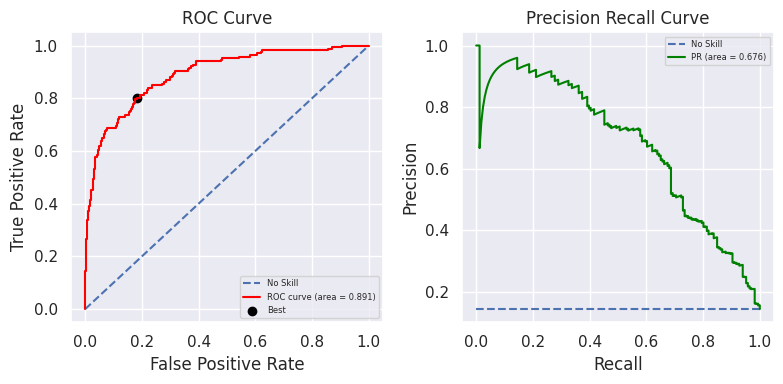

Best Threshold=0.420, G-Mean=0.958


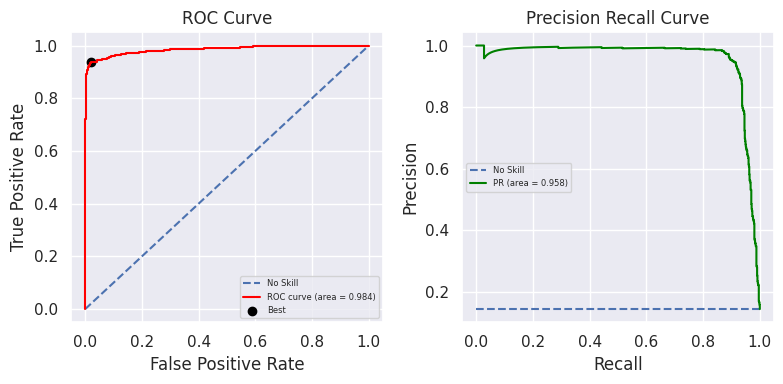

              precision    recall  f1-score   support

         0.0      1.000     0.994     0.997      3956
         1.0      0.964     1.000     0.982       666

    accuracy                          0.995      4622
   macro avg      0.982     0.997     0.989      4622
weighted avg      0.995     0.995     0.995      4622



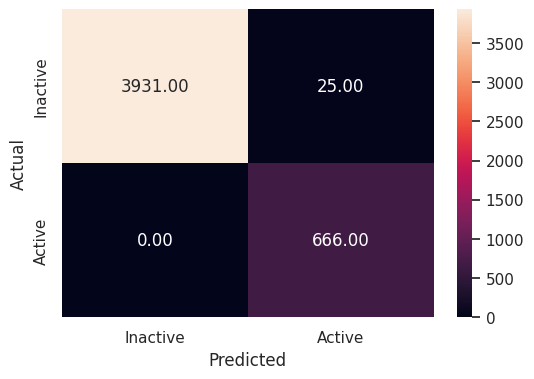

              precision    recall  f1-score   support

         0.0      0.942     0.934     0.938       990
         1.0      0.626     0.657     0.641       166

    accuracy                          0.894      1156
   macro avg      0.784     0.795     0.790      1156
weighted avg      0.897     0.894     0.895      1156



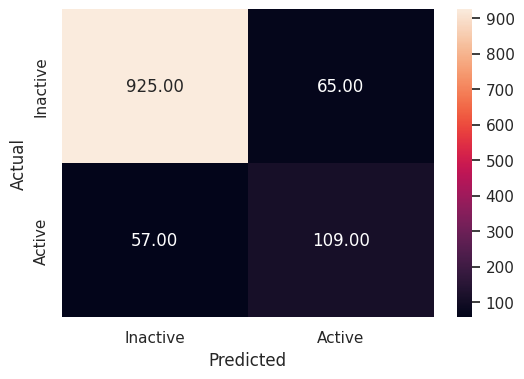

              precision    recall  f1-score   support

         0.0      0.988     0.982     0.985      4946
         1.0      0.896     0.931     0.913       832

    accuracy                          0.975      5778
   macro avg      0.942     0.957     0.949      5778
weighted avg      0.975     0.975     0.975      5778



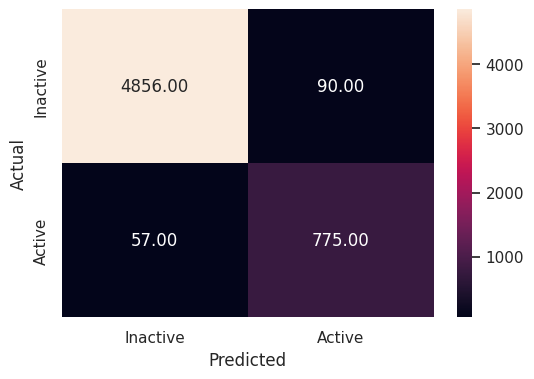

[0]	validation_0-logloss:1.34987
[1]	validation_0-logloss:1.29164
[2]	validation_0-logloss:1.23548
[3]	validation_0-logloss:1.18044
[4]	validation_0-logloss:1.12723
[5]	validation_0-logloss:1.07711
[6]	validation_0-logloss:1.02895
[7]	validation_0-logloss:0.98269
[8]	validation_0-logloss:0.93946
[9]	validation_0-logloss:0.89865
[10]	validation_0-logloss:0.85859
[11]	validation_0-logloss:0.82149
[12]	validation_0-logloss:0.78602
[13]	validation_0-logloss:0.75247
[14]	validation_0-logloss:0.72114
[15]	validation_0-logloss:0.69144
[16]	validation_0-logloss:0.66276
[17]	validation_0-logloss:0.63634
[18]	validation_0-logloss:0.61142
[19]	validation_0-logloss:0.58781
[20]	validation_0-logloss:0.56540
[21]	validation_0-logloss:0.54495
[22]	validation_0-logloss:0.52504
[23]	validation_0-logloss:0.50712
[24]	validation_0-logloss:0.49005
[25]	validation_0-logloss:0.47497
[26]	validation_0-logloss:0.46039
[27]	validation_0-logloss:0.44646
[28]	validation_0-logloss:0.43368
[29]	validation_0-loglos

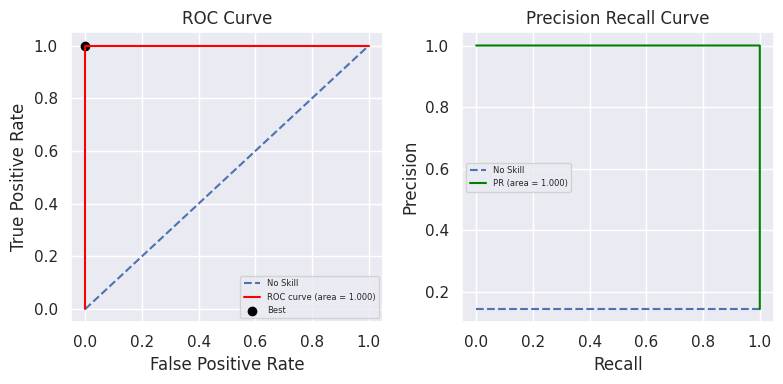

Best Threshold=0.207, G-Mean=0.841


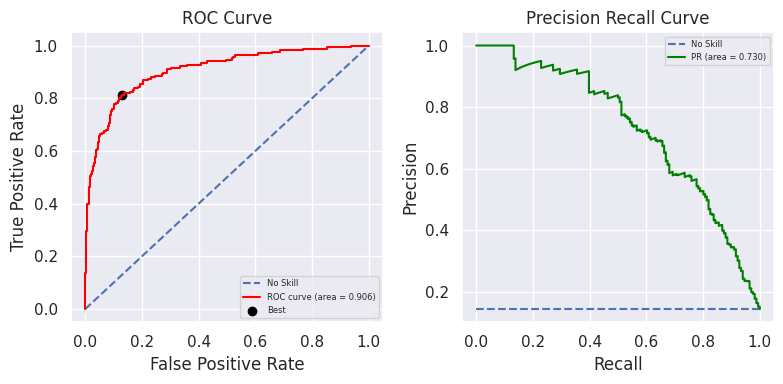

Best Threshold=0.446, G-Mean=0.958


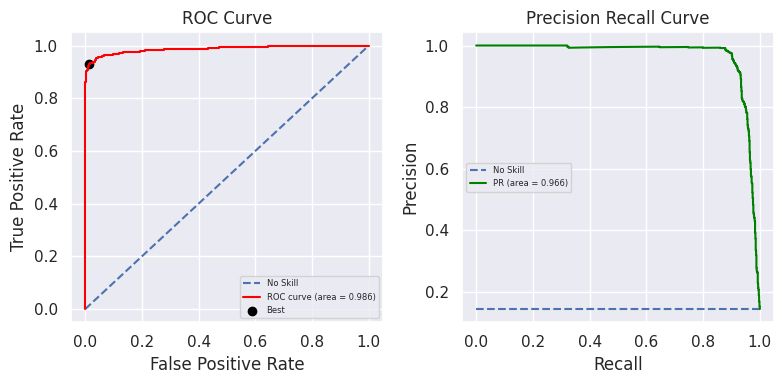

              precision    recall  f1-score   support

         0.0      1.000     0.993     0.997      3956
         1.0      0.962     1.000     0.981       666

    accuracy                          0.994      4622
   macro avg      0.981     0.997     0.989      4622
weighted avg      0.995     0.994     0.994      4622



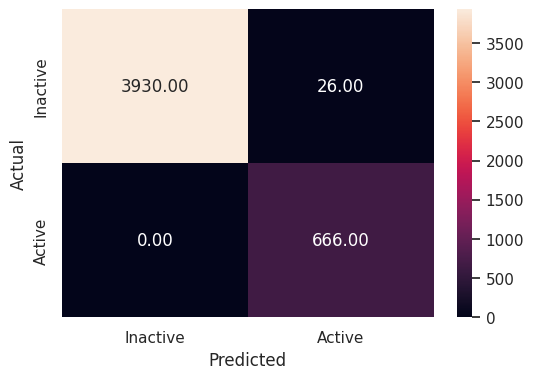

              precision    recall  f1-score   support

         0.0      0.943     0.951     0.947       990
         1.0      0.690     0.657     0.673       166

    accuracy                          0.908      1156
   macro avg      0.816     0.804     0.810      1156
weighted avg      0.907     0.908     0.907      1156



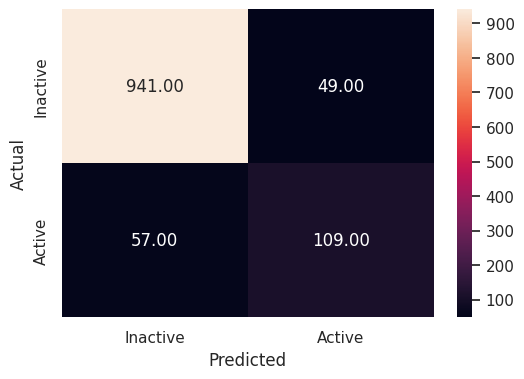

              precision    recall  f1-score   support

         0.0      0.988     0.985     0.987      4946
         1.0      0.912     0.931     0.922       832

    accuracy                          0.977      5778
   macro avg      0.950     0.958     0.954      5778
weighted avg      0.977     0.977     0.977      5778



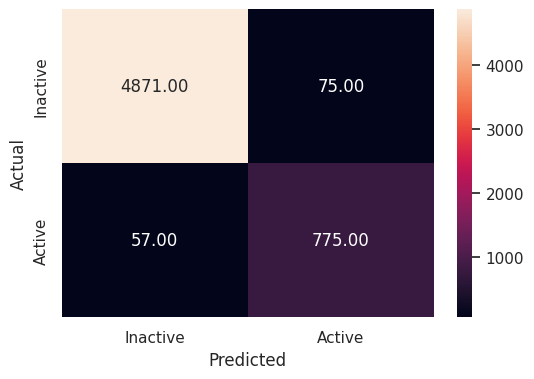

In [ ]:
for train_index, test_index in sss.split(X, Y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    #print("TRAIN indices:", train_index)
    #print("TEST indices:", test_index)
    #print("Distinct classes in TRAIN:", np.unique(y_train))
    #print("Distinct classes in TEST:", np.unique(y_test))
    #print()  # Blank line for better readability
    #Fitting the model
    xgb_cv.fit(
               x_train, y_train,
               eval_set=[(x_test, y_test)],
    )

    metrics_curve(xgb_cv, x_train, y_train)
    metrics_curve(xgb_cv, x_test, y_test)
    metrics_curve(xgb_cv, X, Y)
    #y_pred_test_xgb_cv = xgb_cv.predict(x_test)
    #metrics_score(y_test, y_pred_test_xgb_cv)

    y_train_xgb_cv_proba = xgb_cv.predict_proba(x_train)
    y_train_xgb_cv_prediction = (y_train_xgb_cv_proba [:,1] >= 0.446).astype('int')

    y_test_xgb_cv_proba = xgb_cv.predict_proba(x_test)
    y_test_xgb_cv_prediction = (y_test_xgb_cv_proba [:,1] >= 0.446).astype('int')


    y_overall_xgb_cv_proba = xgb_cv.predict_proba(X)
    y_overall_xgb_cv_prediction = (y_overall_xgb_cv_proba [:,1] >= 0.446).astype('int')


    metrics_score(y_train, y_train_xgb_cv_prediction)
    metrics_score(y_test, y_test_xgb_cv_prediction)
    metrics_score(Y, y_overall_xgb_cv_prediction)

Best Threshold=0.789, G-Mean=1.000


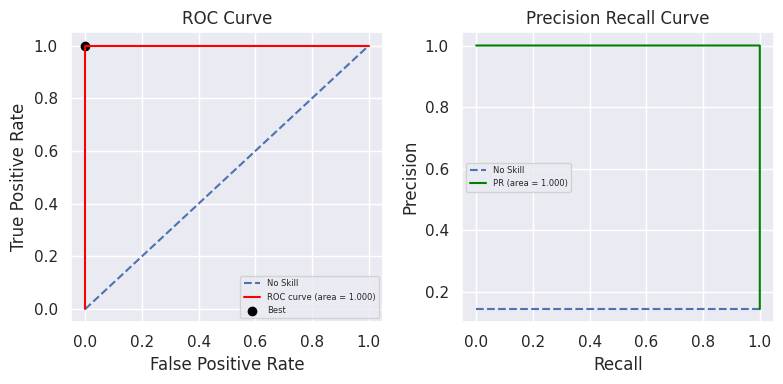

In [ ]:
metrics_curve (xgb_cv, x_train, y_train)

Best Threshold=0.207, G-Mean=0.841


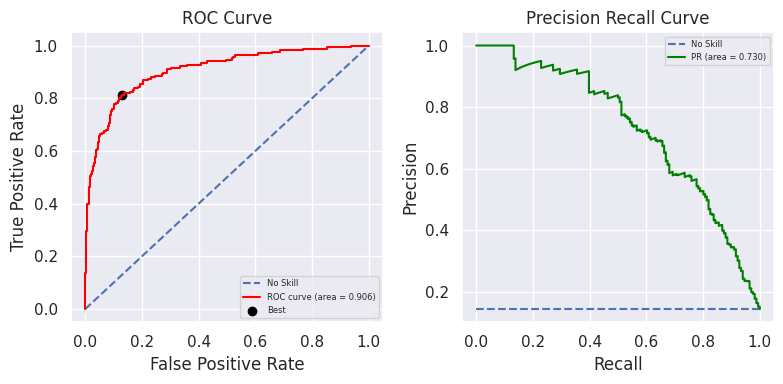

In [ ]:
metrics_curve (xgb_cv, x_test, y_test)

Best Threshold=0.446, G-Mean=0.958


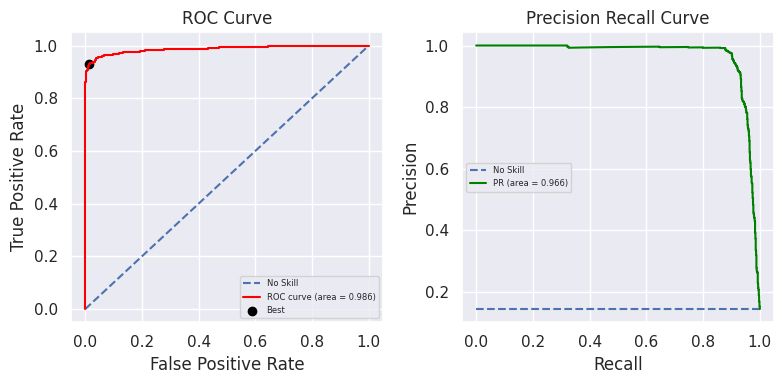

In [ ]:
metrics_curve (xgb_cv, X, Y)

              precision    recall  f1-score   support

         0.0      0.989     0.985     0.987      3956
         1.0      0.912     0.937     0.924       666

    accuracy                          0.978      4622
   macro avg      0.951     0.961     0.956      4622
weighted avg      0.978     0.978     0.978      4622



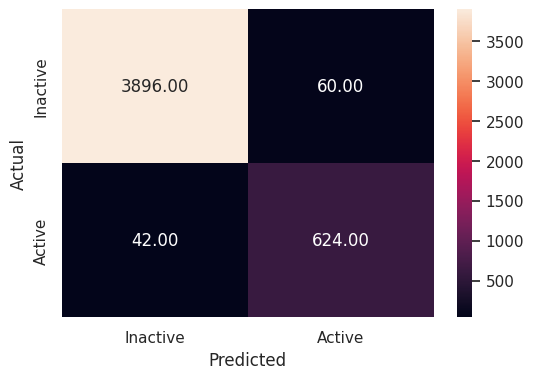

In [ ]:
# Checking the model performance on training data with changed threshold
predicted_proba_train_xgb_cv = xgb_cv.predict_proba(x_train)
y_pred_train_xgb_cv = (predicted_proba_train_xgb_cv[:,1] >= 0.446).astype('int')
metrics_score(y_train, y_pred_train_xgb_cv)

In [ ]:
# Checking the model performance on training data with changed threshold
predicted_proba_test_xgb_cv = xgb_cv.predict_proba(x_test)
y_pred_test_xgb_cv = (predicted_proba_test_xgb_cv[:,1] >= 0.446).astype('int')
metrics_score(y_test, y_pred_test_xgb_cv)

In [ ]:
import joblib
from google.colab import files
joblib.dump(xgb_cv, 'Classification_model_20250918.pkl')  # Save
# Download the file to your local machine
files.download('Classification_model_20250918.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Prediction for all the training dataset**

              precision    recall  f1-score   support

         0.0      0.988     0.985     0.987      4946
         1.0      0.912     0.931     0.922       832

    accuracy                          0.977      5778
   macro avg      0.950     0.958     0.954      5778
weighted avg      0.977     0.977     0.977      5778



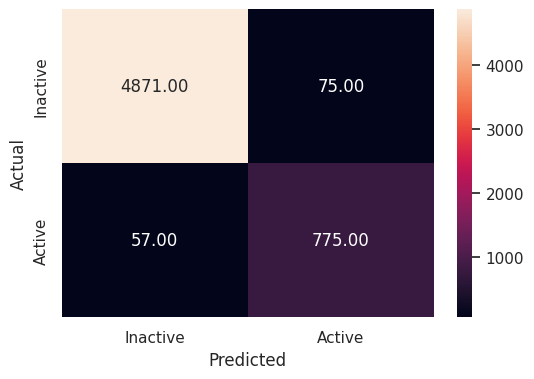

In [ ]:
# Checking the model performance on training data with changed threshold
predicted_proba_xgb_cv = xgb_cv.predict_proba(X)
y_pred_xgb_cv = (predicted_proba_xgb_cv[:,1] >= 0.446).astype('int')
metrics_score(Y, y_pred_xgb_cv)

In [ ]:
import matplotlib.colors as mcolors
# Function to print classification report and get confusion matrix in a proper format
def CM(actual, predicted):
    #print(classification_report(actual, predicted, digits=3))

    cm = confusion_matrix(actual, predicted)

    labels = ['True Negative','False Positive','False Negative','True Positive']

    plt.figure(figsize = (8, 6))
    cmap = mcolors.LinearSegmentedColormap.from_list("CustomMap", ["navajowhite", "lightseagreen"])

    ax = sns.heatmap(cm, annot=True, fmt='.0f',
                 cmap=cmap,
                 xticklabels=['Inactive', 'Active'],
                 yticklabels=['Inactive', 'Active'],
                 annot_kws={"size": 24})

    # Increase tick label font size
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    # Increase font size of color picker (color bar) labels
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=24)  # Adjust color bar tick label size
    # Create a DataFrame for better readability
    #cm_df = pd.DataFrame(cm, index=['Actual Inactive', 'Actual Active'], columns=['Predicted Inactive', 'Predicted Active'])
    #print (cm_df)
    plt.suptitle('Training data', fontsize= 30)
    plt.ylabel('Actual', fontsize = 30)
    plt.xlabel('Predicted',  fontsize = 30)
    plt.tight_layout()
    plt.savefig('Confusion matrix for overall training data.jpg', dpi=600)  # dpi=300 for high resolution
    plt.show()

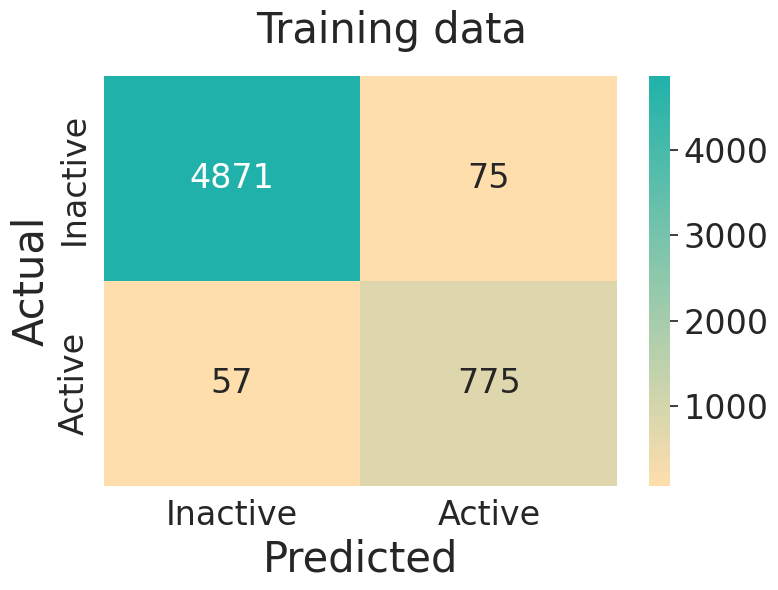

In [ ]:
CM(Y, y_pred_xgb_cv)

In [ ]:
# Convert Series to DataFrame with index as a column
df_prediction = Y.reset_index()

# Rename columns
df_prediction.columns = ['index', 'Label']

df_prediction['prediction'] = y_pred_xgb_cv

In [ ]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5778 entries, 0 to 5777
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       5778 non-null   object 
 1   Label       5778 non-null   float64
 2   prediction  5778 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 135.6+ KB


In [ ]:
df_prediction.to_csv('Prediction_for_Training_dataset_for_classification_submission.csv', index = False)

In [ ]:
df_prediction.head()

index  Label  prediction
0  118409-57-7  0.000           0
1   22204-53-1  0.000           0
2   50505-91-4  0.000           0
3   24140-30-5  1.000           1
4      77-53-2  0.000           0

In [ ]:
df_prediction[df_prediction['index'].str.contains('2051-24-3')]

index  Label  prediction
5768  2051-24-3  1.000           1

In [ ]:
df_prediction[df_prediction['index'].str.contains('2051-24-3')]

index  Label  prediction
5768  2051-24-3  1.000           1

In [ ]:
df_prediction[df_prediction['index'].str.contains('35065-27-1')]

index  Label  prediction
587  35065-27-1  0.000           1

In [ ]:
FN = df_prediction[(df_prediction['Label'] == 1) & (df_prediction['prediction'] == 0)]
FP = df_prediction[(df_prediction['Label'] == 0) & (df_prediction['prediction'] == 1)]

In [ ]:
FN['index']

69       21285-46-1
377      61755-34-8
696        101-37-1
819       2110-18-1
930        532-27-4
1200        95-77-2
1327      3209-13-0
1499        95-69-2
1582       540-23-8
1810     13410-86-1
1892       539-21-9
1970     68377-91-3
2025    198481-33-3
2110     20570-96-1
2206      4093-35-0
2383      2975-34-0
2477       510-15-6
2576     25803-14-9
2625    113136-77-9
2751     16488-48-5
2758       382-67-2
2888        84-75-3
3138     60207-93-4
3194       105-36-2
3332     30748-29-9
3362    131341-86-1
3400     93957-54-1
3449       357-70-0
3661     31386-25-1
3687    125225-28-7
3693     36504-56-0
3732      3804-89-5
3815    101530-10-3
3902      2437-29-8
4069        70-25-7
4075       361-37-5
4106     59467-96-8
4145     89419-40-9
4229     57653-26-6
4373     78281-72-8
4387       553-53-7
4395      3270-71-1
4404       485-47-2
4411      1929-82-4
4434       500-38-9
4612       375-95-1
4705        83-26-1
4719       120-62-7
4826     60207-90-1
4902     85798-08-9
4976     91421-42-0
5043    201677-61-4
5222    380315-80-0
5255    112281-77-3
5410     43121-43-3
5434     35943-35-2
5722     92146-82-2
Name: index, dtype: object

## **Feature importance**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from matplotlib.ticker import FuncFormatter

def plot_train_test_prc(estimator, X_train, y_train, X_test, y_test):
    '''
    Plot Precision-Recall Curves for training and test datasets.
    '''
    # Predict probabilities for the training dataset
    pred_train_prob = estimator.predict_proba(X_train)[:, 1]
    precision_train, recall_train, _ = precision_recall_curve(y_train, pred_train_prob)
    pr_auc_train = auc(recall_train, precision_train)
    # Calculate no skill line for training data
    no_skill = len(y_train[y_train == 1]) / len(y_train)

    # Predict probabilities for the test dataset
    pred_test_prob = estimator.predict_proba(X_test)[:, 1]
    precision_test, recall_test, _ = precision_recall_curve(y_test, pred_test_prob)
    pr_auc_test = auc(recall_test, precision_test)

    # Convert AUC to percentage
    auc_percentage_train = pr_auc_train * 100
    auc_percentage_test = pr_auc_test * 100

    # Plot Precision-Recall Curves
    plt.figure(figsize=(8, 8), facecolor='none')
    plt.plot(recall_train, precision_train, color='green', label=f'Train PRC (area = {auc_percentage_train:.1f}%)')
    plt.plot(recall_test, precision_test, color='black', label=f'Test PRC (area = {auc_percentage_test:.1f}%)')
    # Plot no skill lines as horizontal dashed lines
    plt.axhline(y=no_skill, color='grey', linestyle='--', linewidth=1)
    plt.xlabel('Recall (%)', fontsize = 30)
    plt.ylabel('Precision (%)', fontsize = 30)

    # Major ticks at 0, 0.25, 0.5, 0.75, 1
    ticks = np.linspace(0, 1, 5)
    plt.xticks(ticks, fontsize=24)
    plt.yticks(ticks, fontsize=24)

    # Formatter to show values as 0-100 without '%' sign
    def to_number(x, _):
        return '{:.0f}'.format(x * 100)
    formatter = FuncFormatter(to_number)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    # Set limits slightly wider than [0, 1]
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)

    # Show tick marks on axes spines
    ax.tick_params(direction='out', length=6, width=1)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Make spines visible
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)  # thicker border
        spine.set_edgecolor('black')


    plt.legend(bbox_to_anchor=(0.92, 0.12), loc='lower right', fontsize=24, frameon=False)
    #plt.legend(loc='lower right', fontsize=18, frameon=False)
    ax.set_facecolor('white')
    ax.patch.set_facecolor('none')
    plt.grid(True)
    # Increase spacing above plot for consistency
    plt.tight_layout(pad=1.2)
    plt.savefig('prc_curve.jpg', dpi=600)
    plt.show()

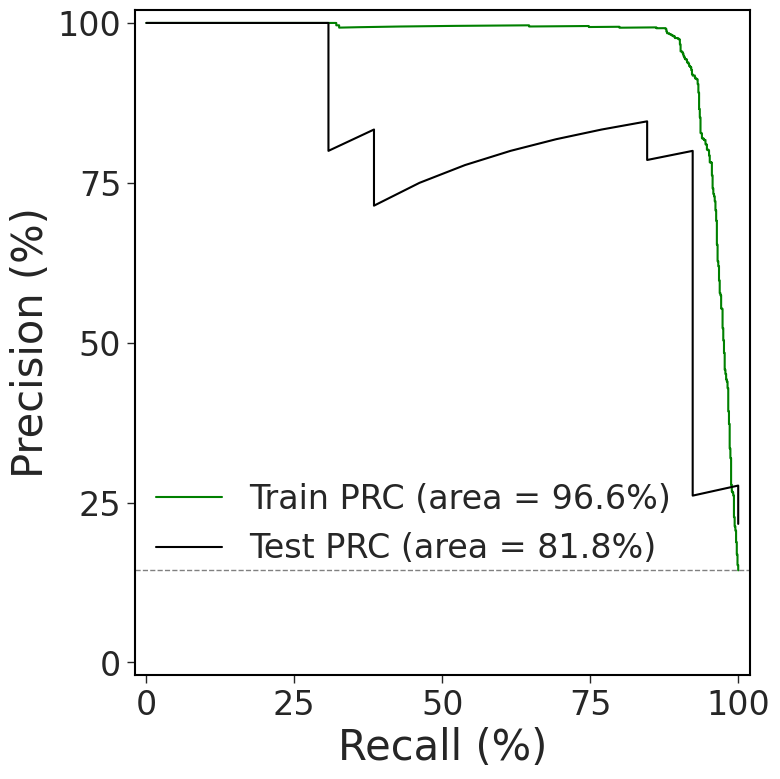

In [ ]:
plot_train_test_prc(xgb_cv, X, Y, X_eval, Y_eval)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from matplotlib.ticker import FuncFormatter

def plot_train_test_roc(estimator, X_train, y_train, X_test, y_test):
    '''
    Plot ROC curves for both training and test datasets on the same figure.
    X-axis ticks are in numbers from 100 to 0 (reversed), no % sign.
    '''
    # Predict probabilities
    pred_train = estimator.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, pred_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    pred_test = estimator.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, pred_test)
    roc_auc_test = auc(fpr_test, tpr_test)


    # Convert AUC to percentage
    auc_percentage_train = roc_auc_train * 100
    auc_percentage_test = roc_auc_test * 100

    plt.figure(figsize=(8, 8), facecolor='none')
    plt.plot(fpr_train, tpr_train, color='green', label='Train ROC (area = %.1f%%)' % auc_percentage_train)
    plt.plot(fpr_test, tpr_test, color='black', label='Test ROC (area = %.1f%%)' % auc_percentage_test)
    plt.plot([-0.02, 1.02], [-0.02, 1.02], linestyle='--', color='grey')

    plt.xlabel('Sensitivity (%)', fontsize=30)
    plt.ylabel('Specificity (%)', fontsize=30)

    # Major ticks at 0, 0.25, 0.5, 0.75, 1
    ticks = np.linspace(0, 1, 5)
    plt.xticks(ticks, fontsize=24)
    plt.yticks(ticks, fontsize=24)

    # Formatter to show values as 0-100 without '%' sign
    def to_number(x, _):
        return '{:.0f}'.format(x * 100)
    formatter = FuncFormatter(to_number)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    # Reverse x-axis tick labels from 100 to 0
    current_labels = [to_number(tick, None) for tick in ticks]
    reversed_labels = list(reversed(current_labels))
    ax.set_xticklabels(reversed_labels)

    # Set limits slightly wider than [0, 1]
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)

    # Show tick marks on axes spines
    ax.tick_params(direction='out', length=6, width=1)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Make spines visible
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    plt.legend(bbox_to_anchor=(1.05, -0.02), loc='lower right', fontsize=24, frameon=False)
    plt.grid(True)
    ax.set_facecolor('white')
    ax.patch.set_facecolor('none')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)  # thicker border
        spine.set_edgecolor('black')
    plt.tight_layout(pad=1.2)
    plt.savefig('roc_curve.jpg', dpi=600)
    plt.show()


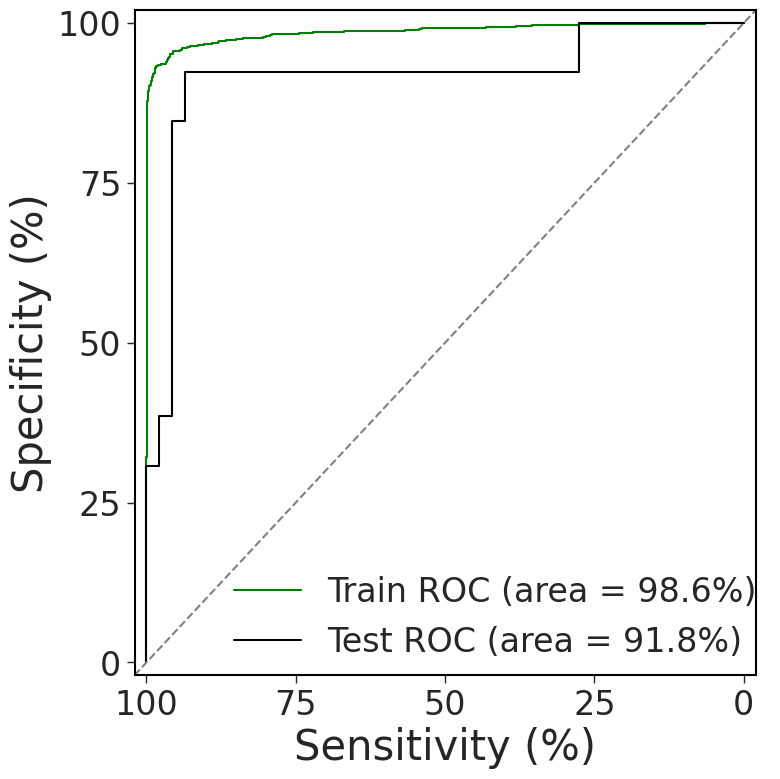

In [ ]:
plot_train_test_roc(xgb_cv, X, Y, X_eval, Y_eval)

In [ ]:
# Plotting the feature importance
features = list(X.columns)
importances = xgb_cv.feature_importances_

indices = np.argsort(importances)

plt.figure(figsize = (50, 200))

plt.title('Feature Importances')

plt.barh(range(len(indices)),importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.xlabel('Relative Importance')

#plt.show()

Text(0.5, 0, 'Relative Importance')

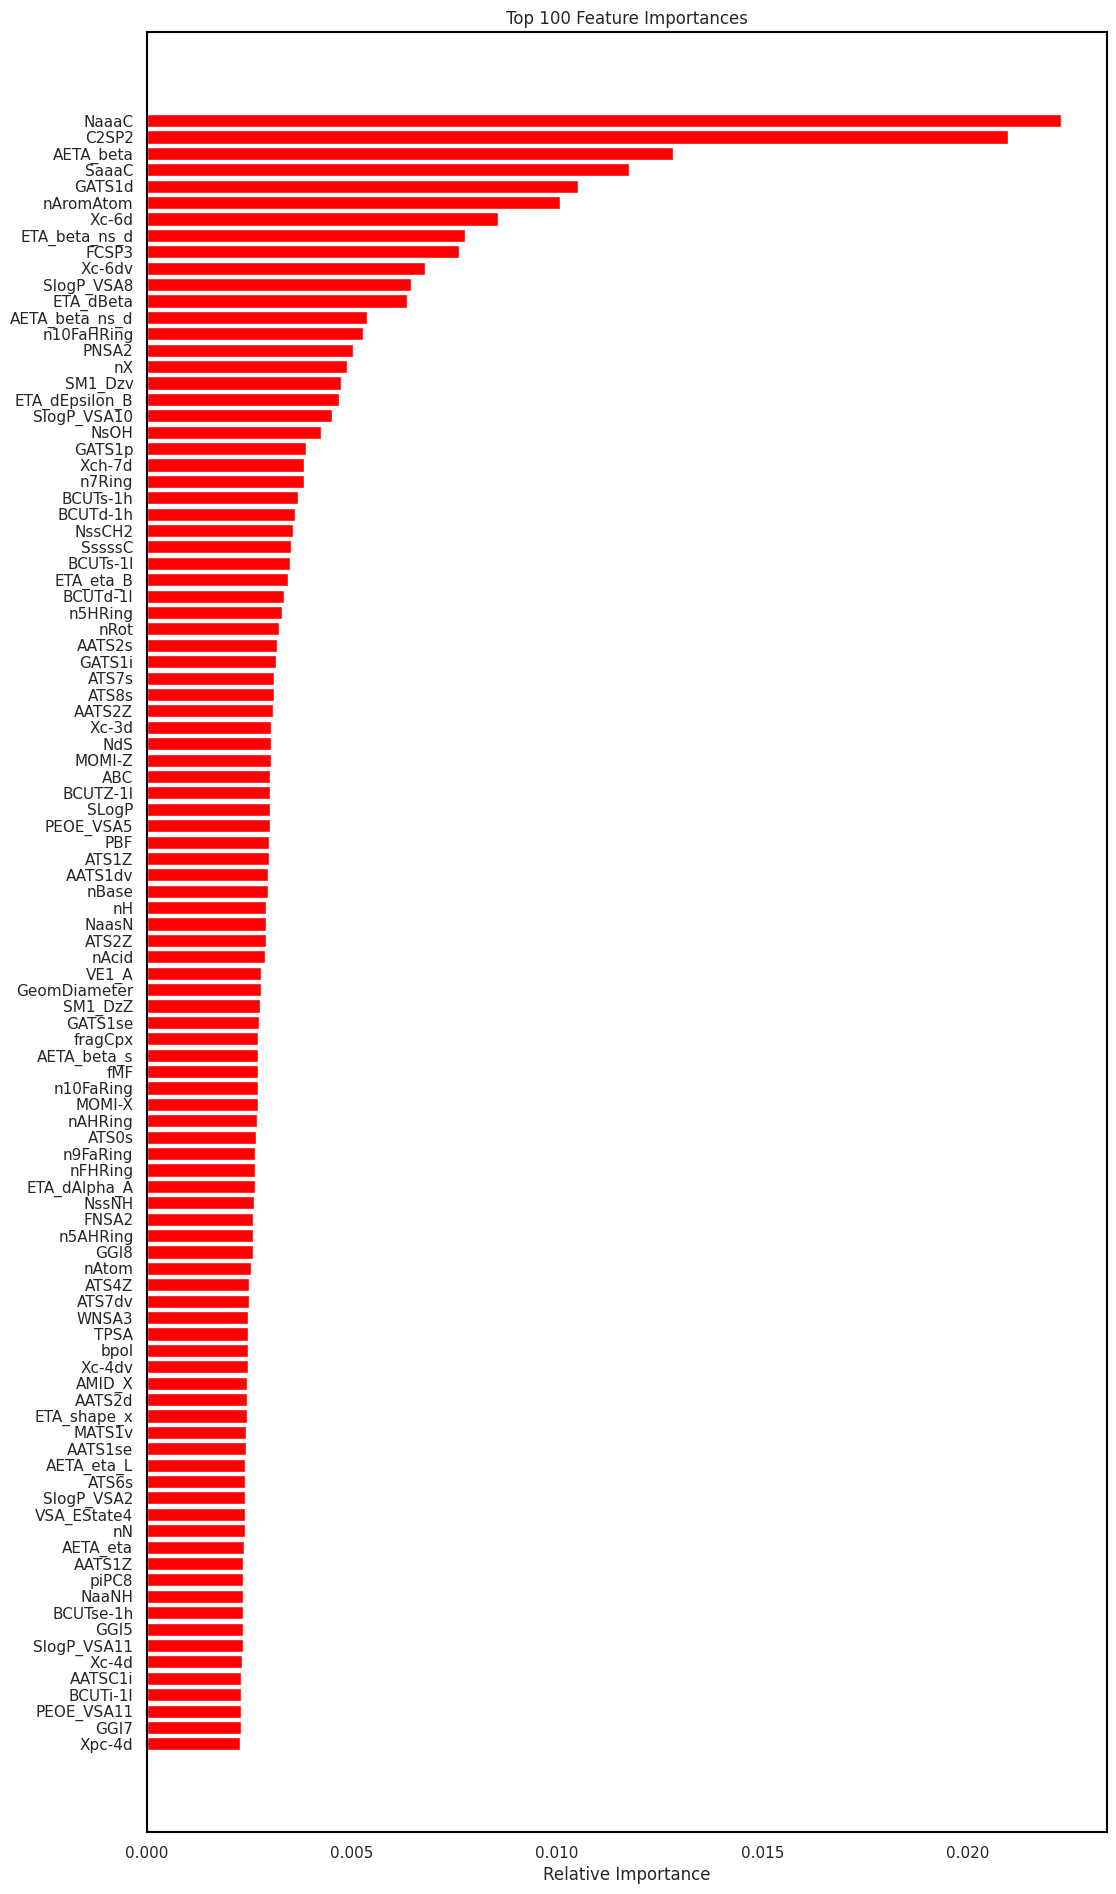

In [ ]:
# Show the top 100 important features
features = list(X.columns)
importances = xgb_cv.feature_importances_

# Get the indices of the top 100 features
top_n = 100
indices = np.argsort(importances)[-top_n:]

fig = plt.figure(figsize=(12, max(10, top_n * 0.2)))
ax = fig.add_axes([0.2, 0.1, 0.8, 0.9])  # [left, bottom, width, height]

ax.barh(range(len(indices)), importances[indices], color='red', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([features[i] for i in indices])

ax.set_xlabel('Relative Importance')
ax.set_title(f'Top {top_n} Feature Importances')

# Style the spines for better visibility
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor('black')

# Optional: remove background fill for axes
ax.set_facecolor('white')
ax.patch.set_facecolor('none')

plt.show()

In [ ]:
importances[139]

np.float32(0.0016484956)

In [ ]:
features.index('C2SP2')

255

In [ ]:
Top = indices[-400:]
feature_filtered = [features[i] for i in Top]
#feature_filtered
# Separating the target variable and other variables
X1 = df_filtered[feature_filtered]
Y1 = df_filtered['Label']
# Splitting the data into train and test sets
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size = 0.20, random_state = 123, stratify = Y1)

## **Validation on in-house dataset**

In [ ]:
#load in-house dataset with calculated 3D descriptors (ihm)
ihm_scaled = pd.read_csv('/content/drive/MyDrive/AhR/10_finalize/ihm_scaled_high_specificity.csv', index_col = 0)
X_eval = ihm_scaled.drop(columns = ['Label'])
Y_eval = ihm_scaled['Label']

In [ ]:
ihm_scaled['Label'].value_counts()

Label
0    47
1    13
Name: count, dtype: int64

              precision    recall  f1-score   support

           0      0.974     0.809     0.884        47
           1      0.571     0.923     0.706        13

    accuracy                          0.833        60
   macro avg      0.773     0.866     0.795        60
weighted avg      0.887     0.833     0.845        60



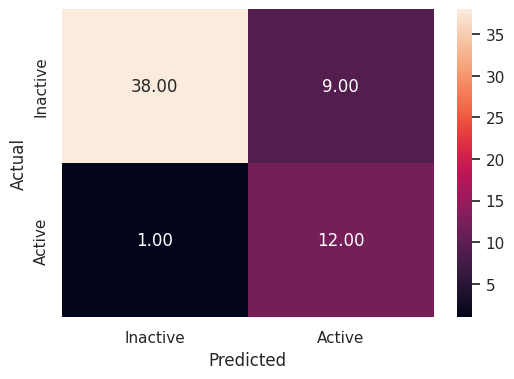

In [ ]:
predicted_proba_eval = xgb_cv.predict_proba(X_eval)
Prediction_eval = (predicted_proba_eval[:,1] >= 0.446).astype('int')
metrics_score(Y_eval, Prediction_eval)

In [ ]:
import matplotlib.colors as mcolors
# Function to print classification report and get confusion matrix in a proper format
def CM(actual, predicted):
    #print(classification_report(actual, predicted, digits=3))

    cm = confusion_matrix(actual, predicted)

    labels = ['True Negative','False Positive','False Negative','True Positive']

    plt.figure(figsize = (8, 6))
    cmap = mcolors.LinearSegmentedColormap.from_list("CustomMap", ["navajowhite", "lightseagreen"])

    ax = sns.heatmap(cm, annot=True, fmt='.0f',
                 cmap=cmap,
                 xticklabels=['Inactive', 'Active'],
                 yticklabels=['Inactive', 'Active'],
                 annot_kws={"size": 24})

    # Increase tick label font size
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)

    # Increase font size of color picker (color bar) labels
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=24)  # Adjust color bar tick label size

    # Create a DataFrame for better readability
    #cm_df = pd.DataFrame(cm, index=['Actual Inactive', 'Actual Active'], columns=['Predicted Inactive', 'Predicted Active'])
    #print (cm_df)
    plt.suptitle('Test data', fontsize=30)
    plt.ylabel('Actual', fontsize = 30)
    plt.xlabel('Predicted',  fontsize = 30)
    plt.tight_layout()
    plt.savefig('Confusion matrix for Test data.jpg', dpi=600)  # dpi=300 for high resolution
    plt.show()

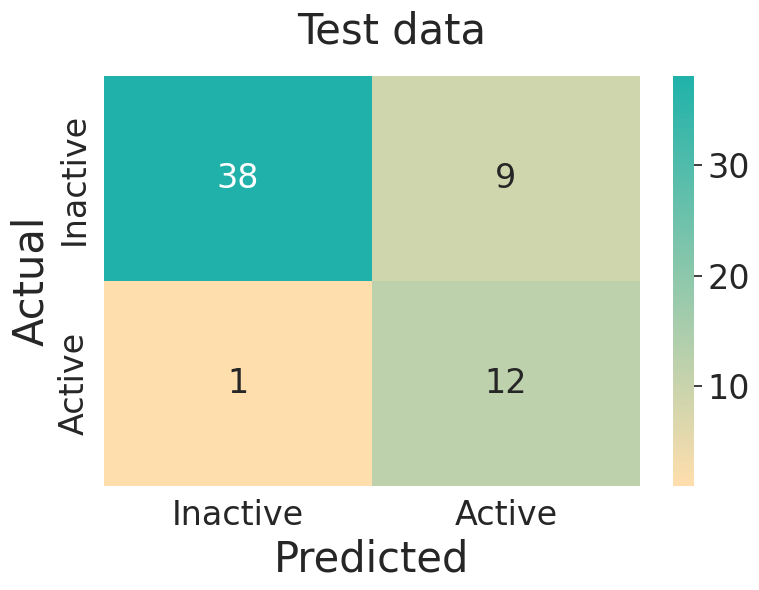

In [ ]:
CM(Y_eval, Prediction_eval)

Best Threshold=0.780, G-Mean=0.930


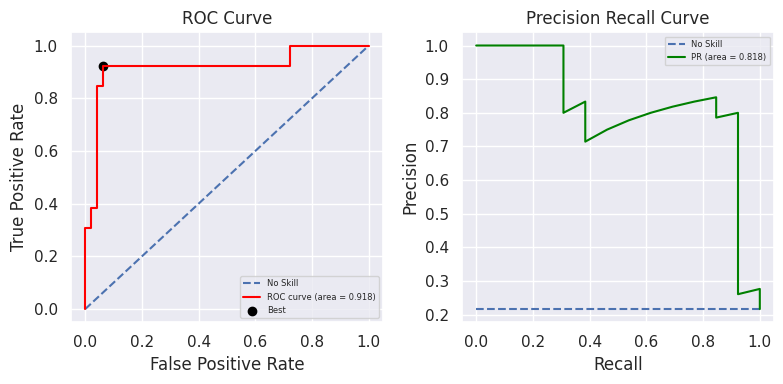

In [ ]:
metrics_curve (xgb_cv, X_eval, Y_eval)

In [ ]:
# Convert Series to DataFrame with index as a column
df_eval = Y_eval.reset_index()

# Rename columns
df_eval.columns = ['CASRN', 'Label']

df_eval['prediction'] = Prediction_eval

In [ ]:
FN = df_eval_SP[(df_eval['Label'] == 1) & (df_eval['prediction'] == 0)]
FP = df_eval_SP[(df_eval['Label'] == 0) & (df_eval['prediction'] == 1)]

In [ ]:
df_eval.to_csv('Prediction_for_in-house_dataset_classification_submission.csv')

## **Prediction for confirmed PAHs**

In [ ]:
df_val = pd.read_csv('/content/df_val_scaled.csv', index_col = 0)

In [ ]:
X_val = df_val.drop(columns = ['AC_10'])

predicted_proba_val = xgb_cv.predict_proba(X_val)
Prediction_val = (predicted_proba_val[:,1] >= 0.446).astype('int')

In [ ]:
## It's all right. Perfect.
Prediction_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

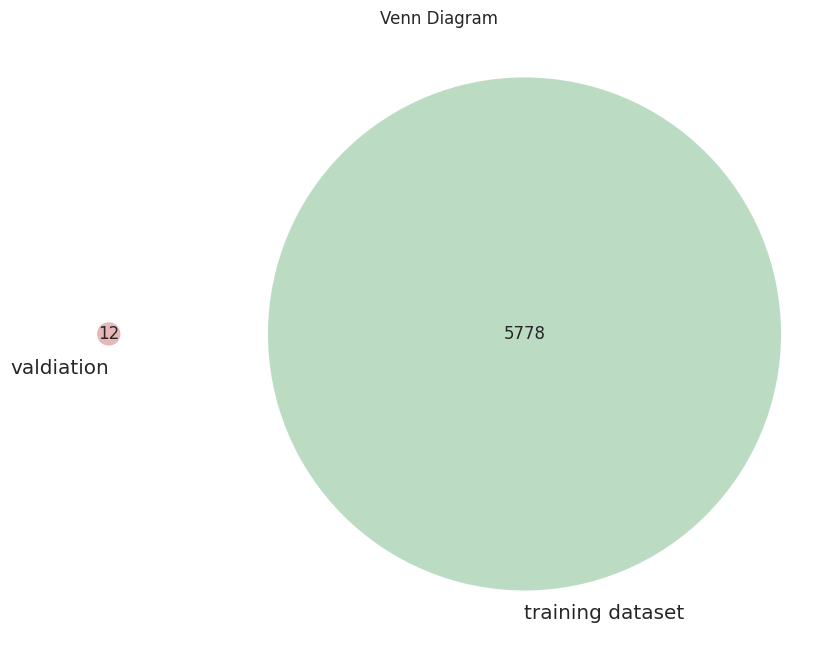

In [ ]:
# show intersection between in house dataset and training dataset for classification
plt.figure(figsize=(10,10))
plt.title("Venn Diagram")

venn2([set(df_val.index.to_list()),
       set(df.index.to_list())],
       set_labels=('valdiation', 'training dataset')
     )

## **Hyperparameter tuning for XGB**

In [ ]:
np.arange(6,16,4)

array([ 6, 10, 14])

In [ ]:
# Choose the type of classifier
xgb_tuned =XGBClassifier(
           nthread = 100,
           device = 'cuda',
           booster = "gbtree",
           tree_method= "gpu_hist",
           sampling_method = 'gradient_based',
           max_delta_step = 1,
           colsample_bylevel= 0.90,
           colsample_bytree= 0.90,
           colsample_bynode= 0.90,
           #subsample = 0.4,
           #max_depth = 8,
           #min_child_weight = 8,
           eta = 0.1,
           early_stopping_rounds = 6,
           gamma = 1,
           scale_pos_weight = 6,
           grow_policy = 'depthwise',
           refresh_leaf = 1,                   ##0 or 1
           #max_leaves = 1,
           updater = 'grow_gpu_hist',
           objective = 'binary:logistic',
           eval_metric = 'logloss',
           base_score = 0.8,
           #num_parallel_tree = 10,             #default is 1
           random_state = 4243)

# Grid of parameters to choose from
parameters = {
             "max_depth": np.arange(4,18,4),
             'min_child_weight': np.arange(4,18,4),
             'subsample':np.arange(0.2,0.8,0.2),
             "num_parallel_tree": np.arange(6,16,4),
             }

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, n_jobs=-1, scoring = 'neg_log_loss', cv = 5)

grid_obj = grid_obj.fit(x_train,
                        y_train,
                        eval_set=[(x_test, y_test)])

# Set the classifier to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

[0]	validation_0-logloss:1.34970
[1]	validation_0-logloss:1.29046
[2]	validation_0-logloss:1.23373
[3]	validation_0-logloss:1.17850
[4]	validation_0-logloss:1.12561
[5]	validation_0-logloss:1.07451
[6]	validation_0-logloss:1.02582
[7]	validation_0-logloss:0.97923
[8]	validation_0-logloss:0.93426
[9]	validation_0-logloss:0.89145
[10]	validation_0-logloss:0.85040
[11]	validation_0-logloss:0.81138
[12]	validation_0-logloss:0.77428
[13]	validation_0-logloss:0.73907
[14]	validation_0-logloss:0.70528
[15]	validation_0-logloss:0.67341
[16]	validation_0-logloss:0.64364
[17]	validation_0-logloss:0.61534
[18]	validation_0-logloss:0.58841
[19]	validation_0-logloss:0.56327
[20]	validation_0-logloss:0.53950
[21]	validation_0-logloss:0.51743
[22]	validation_0-logloss:0.49638
[23]	validation_0-logloss:0.47664
[24]	validation_0-logloss:0.45830
[25]	validation_0-logloss:0.44103
[26]	validation_0-logloss:0.42469
[27]	validation_0-logloss:0.40992
[28]	validation_0-logloss:0.39609
[29]	validation_0-loglos

In [ ]:
grid_obj.best_params_

{'max_depth': np.int64(16),
 'min_child_weight': np.int64(4),
 'num_parallel_tree': np.int64(14),
 'subsample': np.float64(0.6000000000000001)}

In [ ]:
# Fitting the best algorithm to the training data
xgb_tuned.fit(x_train, y_train, eval_set=[(x_test, y_test)])

[0]	validation_0-logloss:1.34970
[1]	validation_0-logloss:1.29046
[2]	validation_0-logloss:1.23373
[3]	validation_0-logloss:1.17850
[4]	validation_0-logloss:1.12561
[5]	validation_0-logloss:1.07451
[6]	validation_0-logloss:1.02582
[7]	validation_0-logloss:0.97923
[8]	validation_0-logloss:0.93426
[9]	validation_0-logloss:0.89145
[10]	validation_0-logloss:0.85040
[11]	validation_0-logloss:0.81138
[12]	validation_0-logloss:0.77428
[13]	validation_0-logloss:0.73907
[14]	validation_0-logloss:0.70528
[15]	validation_0-logloss:0.67341
[16]	validation_0-logloss:0.64364
[17]	validation_0-logloss:0.61534
[18]	validation_0-logloss:0.58841
[19]	validation_0-logloss:0.56327
[20]	validation_0-logloss:0.53950
[21]	validation_0-logloss:0.51743
[22]	validation_0-logloss:0.49638
[23]	validation_0-logloss:0.47664
[24]	validation_0-logloss:0.45830
[25]	validation_0-logloss:0.44103
[26]	validation_0-logloss:0.42469
[27]	validation_0-logloss:0.40992
[28]	validation_0-logloss:0.39609
[29]	validation_0-loglos

XGBClassifier(base_score=0.8, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9,
              device='cuda', early_stopping_rounds=6, enable_categorical=False,
              eta=0.1, eval_metric='logloss', feature_types=None,
              feature_weights=None, gamma=1, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=np.int64(16),
              max_leaves=None, min_child_weight=np.int64(4), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

Best Threshold=0.244, G-Mean=0.962


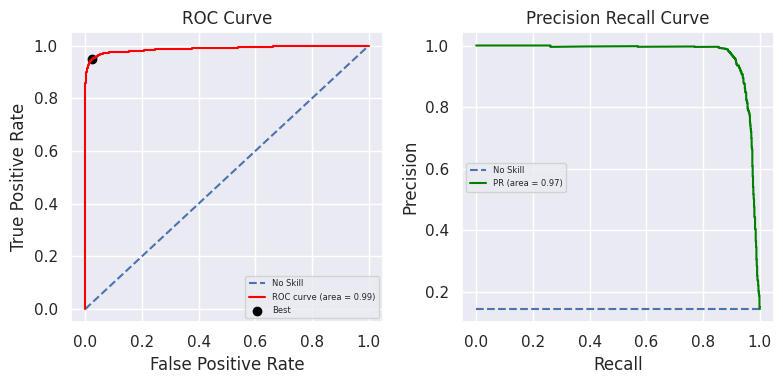

In [ ]:
metrics_curve (xgb_tuned, X, Y)

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       990
         1.0       0.62      0.66      0.64       166

    accuracy                           0.89      1156
   macro avg       0.78      0.80      0.79      1156
weighted avg       0.90      0.89      0.90      1156



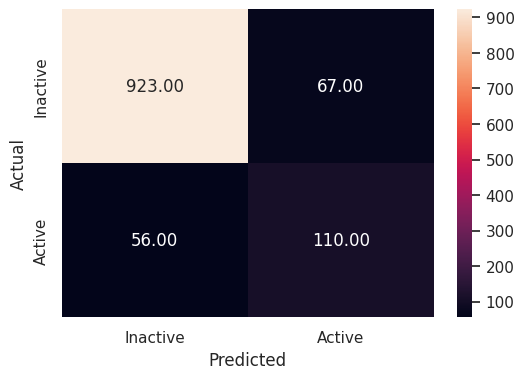

In [ ]:
y_test_xgb_tune_proba = xgb_tuned.predict_proba(x_test)
y_test_xgb_tune_prediction = (y_test_xgb_tune_proba [:,1] >= 0.401).astype('int')
metrics_score(y_test, y_test_xgb_tune_prediction)

## **Prediction for GC target list**

In [ ]:
df_target = pd.read_csv('/content/df_target_scaled.csv', index_col = 0)

In [ ]:
predicted_proba_target = xgb_cv.predict_proba(df_target)
Prediction_target = (predicted_proba_target[:,1] >= 0.446).astype('int')

In [ ]:
## It's all right. Perfect.
Prediction_target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
df_target.head()

ABC  nAcid  nBase  SpMax_A  SpMAD_A  VE1_A  VR1_A  nAromAtom  \
76-01-7  0.086  0.000  0.000    0.425    0.232  0.173  0.000      0.000   
541-73-1 0.111  0.000  0.000    0.425    0.614  0.239  0.000      0.200   
458-88-8 0.124  0.000  0.100    0.411    0.754  0.259  0.001      0.000   
106-46-7 0.111  0.000  0.000    0.423    0.714  0.240  0.000      0.200   
95-50-1  0.110  0.000  0.000    0.436    0.720  0.236  0.000      0.200   

          nAtom  nSpiro  nBridgehead  nHetero    nH    nC    nN    nO    nS  \
76-01-7   0.047   0.000        0.000    0.208 0.016 0.023 0.000 0.000 0.000   
541-73-1  0.085   0.000        0.000    0.083 0.065 0.116 0.000 0.000 0.000   
458-88-8  0.217   0.000        0.000    0.042 0.274 0.163 0.100 0.000 0.000   
106-46-7  0.085   0.000        0.000    0.083 0.065 0.116 0.000 0.000 0.000   
95-50-1   0.085   0.000        0.000    0.083 0.065 0.116 0.000 0.000 0.000   

            nP    nF   nCl   nBr    nI    nX  ATS0dv  ATS7dv  ATS0s  ATS2s  \
76-01-7  0.000 0.000 0.417 0.000 0.000 0.208   0.018   0.000  0.005  0.015   
541-73-1 0.000 0.000 0.167 0.000 0.000 0.083   0.047   0.000  0.015  0.038   
458-88-8 0.000 0.000 0.000 0.000 0.000 0.000   0.034   0.000  0.024  0.072   
106-46-7 0.000 0.000 0.167 0.000 0.000 0.083   0.047   0.000  0.015  0.038   
95-50-1  0.000 0.000 0.167 0.000 0.000 0.083   0.047   0.000  0.015  0.038   

          ATS3s  ATS6s  ATS7s  ATS8s  ATS0Z  ATS1Z  ATS2Z  ATS3Z  ATS4Z  \
76-01-7   0.004  0.000  0.000  0.000  0.114  0.144  0.190  0.159  0.000   
541-73-1  0.012  0.000  0.000  0.000  0.053  0.107  0.069  0.056  0.035   
458-88-8  0.031  0.013  0.010  0.004  0.016  0.105  0.058  0.049  0.025   
106-46-7  0.013  0.000  0.000  0.000  0.053  0.107  0.069  0.056  0.019   
95-50-1   0.013  0.000  0.000  0.000  0.053  0.107  0.069  0.079  0.019   

          ATS5Z  ATS8Z  AATS0dv  AATS1dv  AATS0d  AATS2d  AATS0s  AATS1s  \
76-01-7   0.000  0.000    0.083    0.145   0.388   0.164   0.011   0.041   
541-73-1  0.004  0.000    0.141    0.237   0.304   0.314   0.028   0.192   
458-88-8  0.031  0.001    0.043    0.073   0.115   0.178   0.010   0.080   
106-46-7  0.035  0.000    0.141    0.237   0.304   0.307   0.028   0.192   
95-50-1   0.004  0.000    0.141    0.241   0.304   0.307   0.028   0.193   

          AATS2s  AATS0Z  AATS1Z  AATS2Z  AATS0v  AATS0se  AATS1se  AATS0p  \
76-01-7    0.029   0.095   0.262   0.094   0.410    0.518    0.540   0.147   
541-73-1   0.064   0.029   0.093   0.021   0.244    0.184    0.238   0.074   
458-88-8   0.031   0.001   0.012   0.002   0.039    0.048    0.153   0.014   
106-46-7   0.064   0.029   0.093   0.021   0.244    0.184    0.238   0.074   
95-50-1    0.064   0.029   0.093   0.021   0.244    0.184    0.238   0.074   

          AATS1p  AATS2p  AATS0i  AATS1i  AATS2i  ATSC0c  ATSC1c  ATSC2c  \
76-01-7    0.320   0.175   0.335   0.383   0.453   0.029   0.820   0.386   
541-73-1   0.203   0.097   0.285   0.306   0.311   0.010   0.827   0.405   
458-88-8   0.088   0.033   0.394   0.442   0.447   0.036   0.817   0.395   
106-46-7   0.203   0.097   0.285   0.306   0.311   0.010   0.827   0.405   
95-50-1    0.203   0.097   0.285   0.306   0.311   0.012   0.828   0.394   

          ATSC3c  ATSC4c  ATSC5c  ATSC6c  ATSC7c  ATSC8c  ATSC0dv  ATSC1dv  \
76-01-7    0.642   0.352   0.565   0.332   0.592   0.462    0.027    0.351   
541-73-1   0.627   0.355   0.564   0.332   0.592   0.462    0.067    0.369   
458-88-8   0.629   0.353   0.563   0.333   0.594   0.463    0.077    0.394   
106-46-7   0.635   0.345   0.569   0.332   0.592   0.462    0.067    0.369   
95-50-1    0.639   0.352   0.564   0.332   0.592   0.462    0.067    0.373   

          ATSC2dv  ATSC3dv  ATSC4dv  ATSC5dv  ATSC6dv  ATSC7dv  ATSC8dv  \
76-01-7     0.299    0.587    0.464    0.632    0.536    0.612    0.450   
541-73-1    0.276    0.563    0.463    0.645    0.536    0.612    0.450   
458-88-8    0.298    0.556    0.444    0.622    0.539    0.621    0.455   
106-46-7    0

In [ ]:
# Convert Series to DataFrame with index as a column
df_prediction_target = pd.DataFrame({
    'CASRN': df_target.index.tolist(),
    'Classification_prediction': Prediction_target})

In [ ]:
df_prediction_target.to_csv('df_prediction_target.csv', index = False)

## **Prediction for all candidates**

In [ ]:
df_all = pd.read_csv('/content/df_all_scaled.csv', index_col = 0)

In [ ]:
predicted_proba_all = xgb_cv.predict_proba(df_all)
Prediction_all = (predicted_proba_all[:,1] >= 0.446).astype('int')

In [ ]:
# Convert Series to DataFrame with index as a column
df_prediction_all = pd.DataFrame({
    'CIDs': df_all.index.tolist(),
    'Classification_prediction': Prediction_all})

In [ ]:
df_prediction_all.head()

CIDs  Classification_prediction
0   136590                          0
1    11000                          0
2  5368360                          0
3     1140                          0
4   140946                          0

In [ ]:
df_prediction_all.to_csv('df_prediction_all.csv', index = False)